# Appendix A: method for imputing values for censored data

## Overview

Appendix A focuses on imputing values for the records in the housing dataset with a censored housing_median_age.  This variable is capped at age 52, with approximately 6% of the data (1,268 records) having this cap.  

Appendix B focuses on imputing values for the records with a capped median_house_value.

Values are imputed using a Gibbs sampler.  It involves running, in this case, four random walks simultaneously.  In each, the first step is to randomly assign values from the expected imputation range to the records with censored values.  The data is then modeled.  New predictions are obtained using coefficients randomly sampled from the uncertainty distributions of the model's parameters.  With the new predictions, another model is obtained.  We repeat this process many times, essentially until we see the separate random walks converge in their estimates of the parameter means.  The Gibbs sampler output includes predictions for the imputed values that we need.  These predictions are normally distributed, and the spread of the distribution depends on the R-squared of the model we employ and the range in which we expected the imputed values to lie.  The smaller we make this range, the smaller the spread of our imputed values.  The greater the R-squared of the model we rely on, the smaller the spread of the imputed values.  While smaller spreads are preferable, we do not want to choose a range for the imputed values that is likely to capture only 80% of the size of the actual range.  E.g., for housing_median_age, we expect that there are districts with an age of 65, but it is not so clear that we will find many with an age > 85.  If we expect that only around 1% of the districts have an age > 78, then we will end up with a much better set of predictions, on average, keeping the upper limit of the imputation range at 78 or slightly below.

Because the models in Appendix A and Appendix B assume that the response variable is normally distributed, the Gibbs samplers relying on these models will always generate predictions which are normally distributed around a mean.  But this shape for the imputed values is not what we necessarily expect to see.  In Section 1 below, the analysis aims to provide a clearer picture of what this shape might be; it provides predictions for the location of the mean and the median of the actual, unobserved values of the censored records.  In Section 2 these predictions are then used to adjust the output from the Gibbs sampler.  Both here and in Part01 I then check that the adjustment to the Gibbs sampler output is still consistent with the data.  (There are 2 distinct validity checks.)

In Appendix C, I look at the degree to which the imputed values reduce the noise found in the capped data.


                                      * * * * *
                                      

# Section 1: Get predictions for medians and means

We want our imputed values to have a distribution similar to that which the actual, unobserved values are likely to have.  Because the imputation range is the tail of the distribution of ages, the task is made much easier; the frequency counts will almost certainly decrease.  In this instance we will need to rely on historical knowledge for a sense of how far the tail might extend to the right, and what the upper limit might be for the vase majority of housing median ages.  But we can make use of the data we already have to get a good idea of where the mean and the median of the distribution might lie.  This section shows one way we can get good predictions for the mean.  Good predictions for the median are much harder to obtain, although we can safely assume (as discussed further below) that the median will be to the left of the mean.


                                        * * * * *

In [ ]:
# Load some of the packages we will use.

require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm) 


In [2]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [3]:
# Start with the 20.6K records in housing_cleaned_v02.csv.  This
# is the data I start with at the beginning of Section 2 of Part01.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v02.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

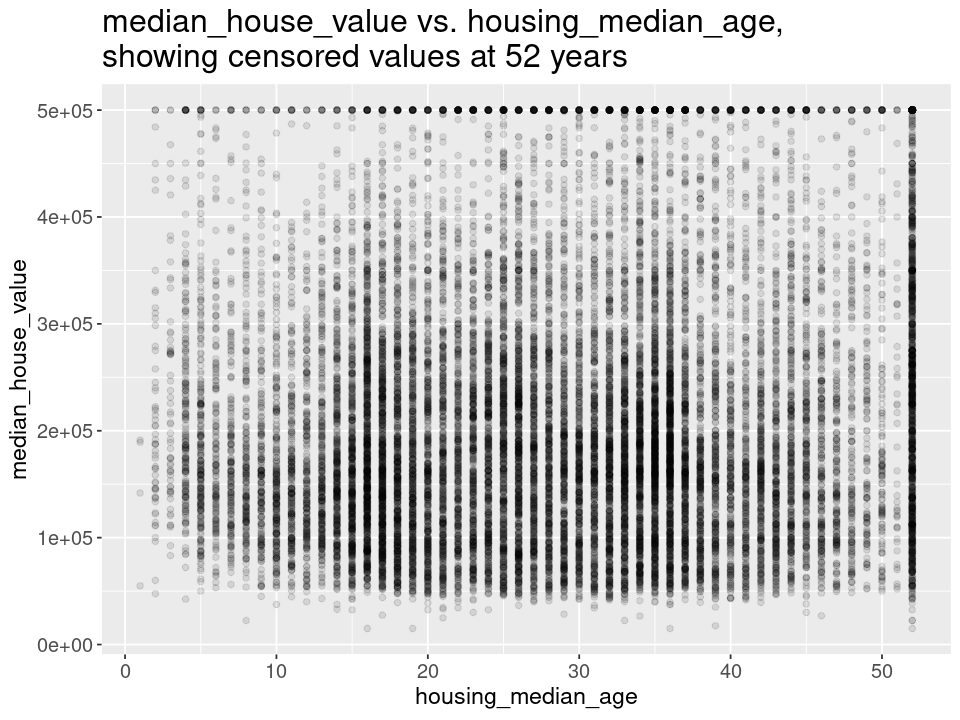

In [4]:
# Plot of median_house_value vs. housing_median_age. 
# 6.15% of the data is censored at age 52.
# median_house_value is also censored at 500K.

options(repr.plot.width= 8, repr.plot.height= 6)

p <- ggplot(dat, aes(housing_median_age, median_house_value)) +
  geom_point(alpha= 0.1) + xlab("housing_median_age") + ylab("median_house_value") +
  ggtitle("median_house_value vs. housing_median_age, 
showing censored values at 52 years") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
  
p


In [43]:
# There are 1268 records, or districts, with a 
# censored housing_median_age.

nrow(dat[which(dat$housing_median_age >= 52),])


[1] 1268

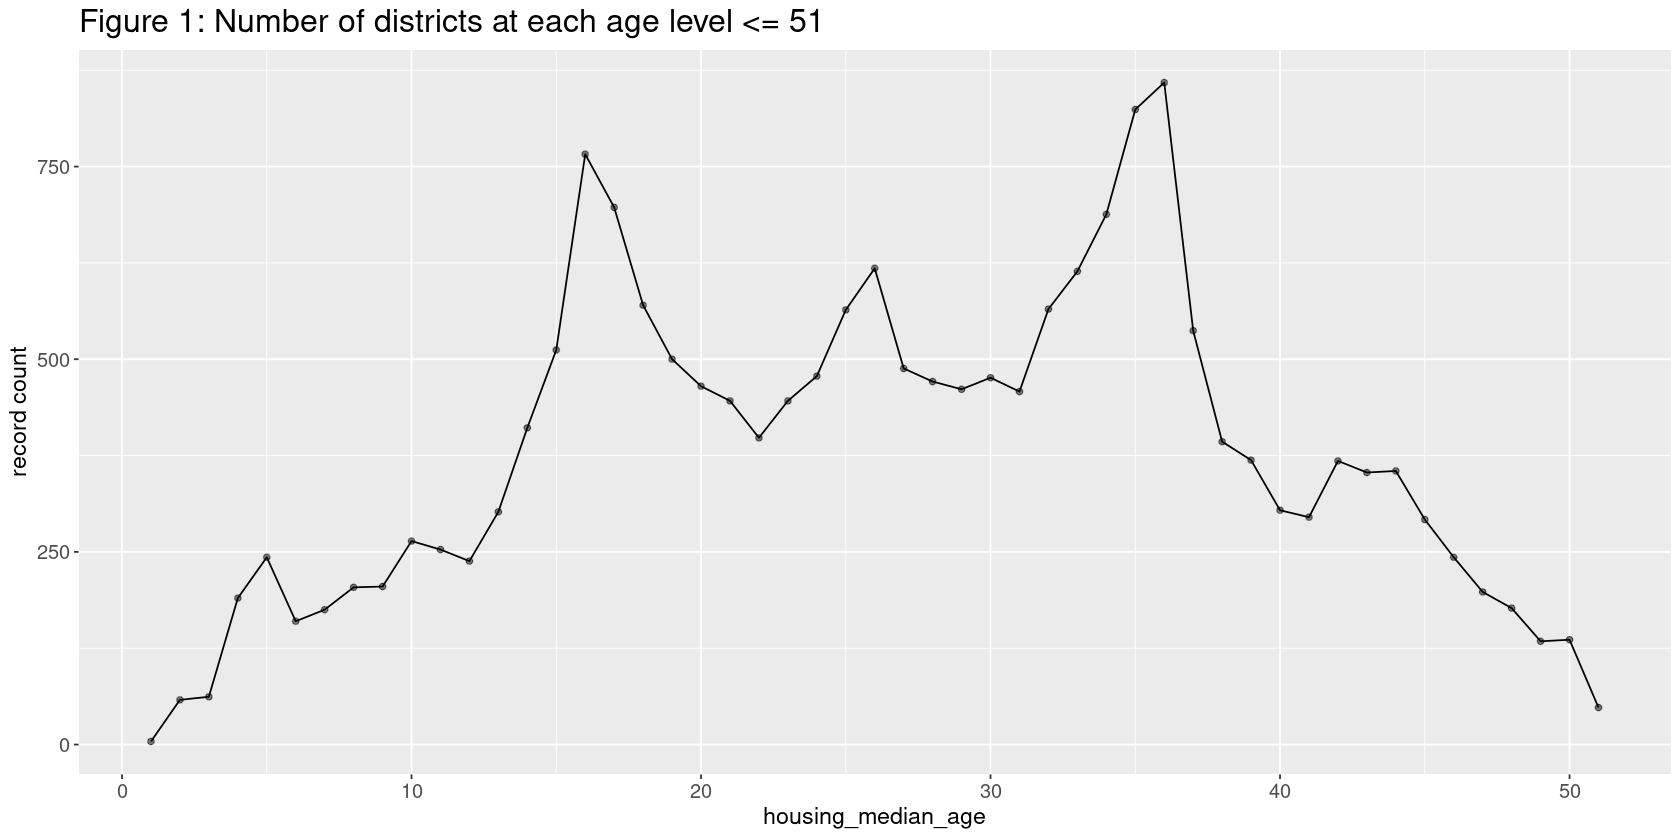

In [5]:
# Construct a dataframe for plotting the number of districts
# at each age level.  This will give us a very general idea
# of what the distribution of counts might look like for the
# 1268 records which need an imputed value.  We are interested
# in the general shape of the distribution when age is > 43.

ans <- table(as.factor(dat$housing_median_age))[1:51]
df_age <- rep(NA, 2 * length(ans))
dim(df_age) <- c(length(ans), 2)
df_age <- as.data.frame(df_age)
colnames(df_age) <- c("age", "count")
df_age$age <- as.numeric(names(ans))
df_age$count <- as.numeric(ans)


options(repr.plot.width= 14, repr.plot.height= 7)

p <- ggplot(df_age, aes(age, count)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + ylab("record count") +
  geom_line() +
  ggtitle("Figure 1: Number of districts at each age level <= 51") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [6]:
tail(df_age)


,age,count
,<dbl>,<dbl>
46,46,243
47,47,198
48,48,177
49,49,134
50,50,136
51,51,48


In [7]:
round(sd(df_age$count),1)


[1] 203.3

In [6]:
# Creating an example distribution beyond age 51 will help us
# get a sense of what predictions are plausible for the
# mean and median of the true, unobserved ages beyond age 51.
# See plot that follows.

# Possible counts for ages 52:82.  We expect the counts
# to decrease as we move further to the right.
mydist <- c(130, 125, 120, 112, 108, 100, 93, 80, 73, 66,
            60, 49, 40, 35, 30, 22, 15, 0, 0, 5, 0, 0, 3,
            0, 0, 0, 1, 0, 0, 0, 1)
sum(mydist)
# 1268

observed <- as.numeric(df_age[which(df_age$age >= 22),]$count)

all <- c(observed, mydist)
n <- length(22:82)

dftmp <- rep(NA, 2 * n)
dim(dftmp) <- c(n, 2)
dftmp <- as.data.frame(dftmp)
colnames(dftmp) <- c("age", "count")
dftmp$age <- 22:82
dftmp$count <- all


[1] 1268

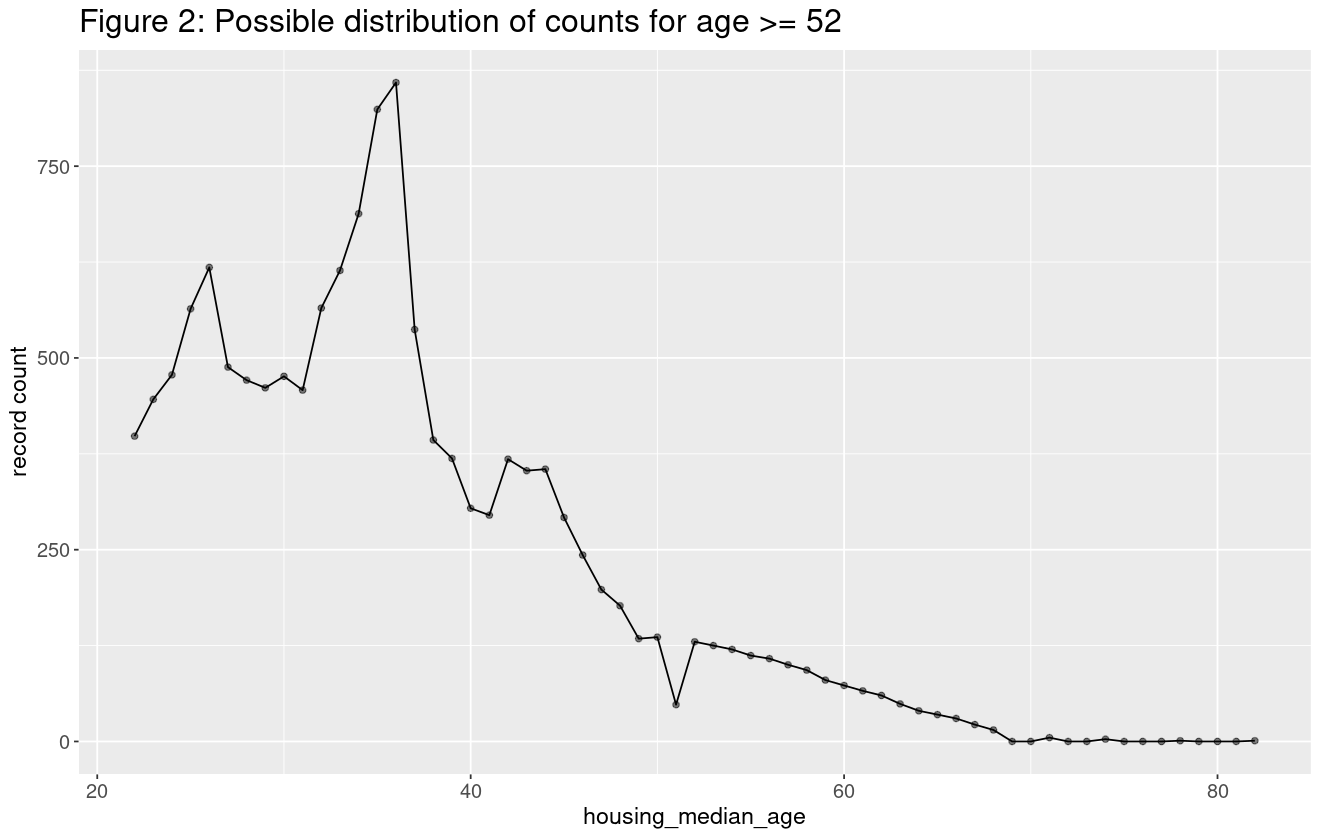

In [21]:
# Plot to show possible distribution of 1268 districts 
# beyond age 51.

options(repr.plot.width= 11, repr.plot.height= 7)

p <- ggplot(dftmp, aes(age, count)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + ylab("record count") +
  geom_line() +
  ggtitle("Figure 2: Possible distribution of counts for age >= 52") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [17]:
# The sharp drop in the counts from ages 36 to 51 leads me
# to think that the counts from age 52 on will drop even
# more quickly than what is shown in the above plot.  E.g.,
# if nearly all of the 1268 censored districts have ages
# <= 63, then the mean and median shown here
# (57.7 and 57 respectively) might be a bit too high. 

round(sum(mydist * 52:82)/sum(mydist), 1)
# 57.7
round(median(rep(52:82, mydist)), 1)
# 57


[1] 57.7

[1] 57


 52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68 
130 125 120 112 108 100  93  80  73  66  60  49  40  35  30  22  15 

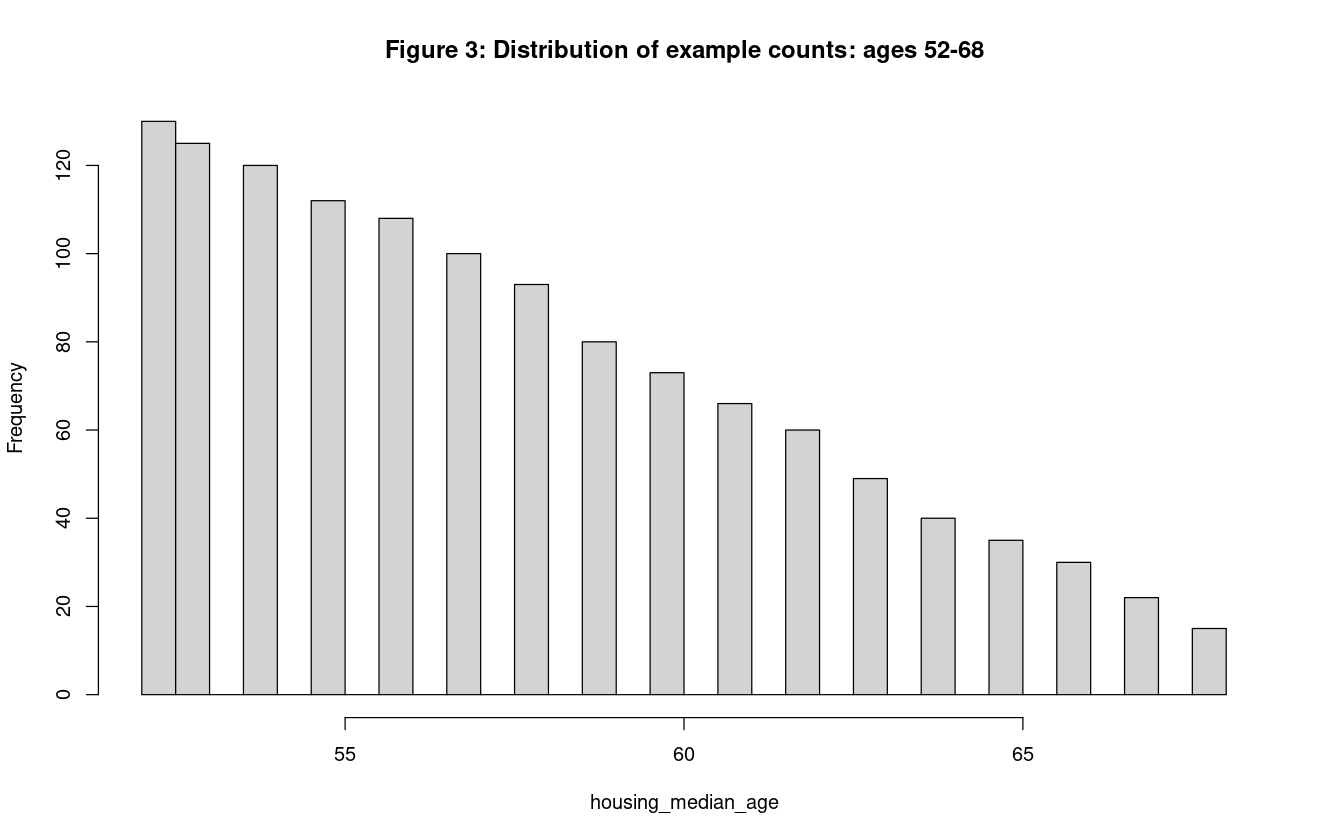

In [28]:
# The histogram below shows the counts for mydist; this
# is a close-up of the far right of Figure 2.

tbl <- table(as.factor(rep(52:68, mydist[1:17]))); tbl

options(repr.plot.width= 11, repr.plot.height= 7)

hist(rep(52:68, mydist[1:17]), breaks=30, xlab="housing_median_age",
     main="Figure 3: Distribution of example counts: ages 52-68")


In [ ]:
### COMMENTS for Figures 1, 2, and 3:

############################################################# 

# In Figure 1 above, from age 36 onwards, the trend is
# a very sharp drop in the counts.  For age 52 and beyond, 
# the number of districts we would expect to see for each
# age level is < 177, more likely < 140.  That number is 
# likely to decrease relatively quickly the further out we 
# go from age 52.  I have tried to capture one plausible
# scenario for the tailing off of the counts; this is
# shown in Figures 2 and 3.

# The sharp drop in the counts from age 36 onwards is something
# to keep in mind when predicting for the mean and median.
# There are only 1268 districts with an age >= 52. In Figure 2 
# the downward trend roughly approximates a negative exponential
# curve.  We can see in Figure 3 how the counts might approximate a
# half-normal curve for ages > 51.  If the shape of the distribution
# of actual counts is half-normal, it would mean that the mean and 
# median we currently have for mydist are a bit high.  Of course,
# the mean might stay around 57-58 if we have districts even
# further to the right, beyond age 82.  But outliers will not  
# change the median much, if at all.

# A median around 56-57 looks to be very plausible.  A mean 
# slightly above this is also quite plausible.  It does not
# appear plausible, to me anyway, that we would have a median
# greater than 59 or a mean greater than 61.

# The above example distribution is an important reference.  In
# what follows we will see 3 predictive models, all with an 
# adjusted R-squared of 1, but only one of which gives us an
# acceptable prediction.  None of the 3 models take into account
# the sharp drop-off in counts after age 51.  In the real world, we 
# know that there is a natural limit to what the housing_median_ages
# can be and that beyond a certain point we will find only outliers.
# Thus, we expect a sharp drop-off in the counts, with a few outliers.  
# But the models below, with the very high R-sqrd values, do not know
# this, and I do not know of any easy way to add such information to
# the models.  Thus, the above material on counts and the shape of 
# the distribution of counts is meant to ground us in our judgments
# regarding the output of the following predictive models.

#############################################################



## Shift increment ratios for mean and median

There is high variability in the above counts, but far less for the shift increment ratios that I make use of in this next section.  These ratios are used to predict the mean and median of the imputed age values.  For the first set of ratios, I look out 1.6 times (1.6X) the value of the starting point, or cap.  For example, if we artificially capped our data at year 32, I am interested in the mean and median of the counts in the range \[32, 51\].  As we see, the 1.6X ratios are not nearly as helpful as the 31-year and 15-year ratios.  Using the latter, we can make fairly good predictions for the mean and the median of the counts when the cap is at 52.  We can then use these initial predictions to help us impute values for the records with a censored housing_median_age.  With the imputed values in hand, we can then iterate the process to get better predictions for the mean and median; if the predictions change much, we can incorporate the new information into a second round of imputed values. 


                                    * * * * *



In [8]:
mean_ratios <- median_ratios <- rep(NA, length(2:32))
means <- medians <- rep(NA, length(2:32))
rcd_count <- rep(NA, length(2:32))


# We look out 1.6X the value of the cap.  Why 1.6 when 1.6*52
# is only 83 and there might be a few districts with a
# housing median age > 83?  There are three reasons: (i) the
# more we increase the span, the fewer datapoints we have to
# work with for understanding the pattern/trajectory of the 
# means and medians; and (ii) the further out we set the upper 
# limit, the larger the standard errors are for the imputed values; 
# the large standard errors are not helpful when we expect < 1% 
# of the true, unobserved ages for the 1268 records to be > 83;
# this expectation ought to be incorporated into the  imputation
# process; and (iii) even if 83 is a bit too low for the upper 
# limit, this will affect the mean of the distribution in the 
# range of imputation but not the median, given the small number
# of districts we expect to find beyond this upper limit.  This 
# is why we also want to collect information on the medians.

span <- 1.6

for(cur_age in 2:32) {
    
    agevals <- as.numeric(dat[which((dat$housing_median_age >= cur_age) &
                        (dat$housing_median_age <= round(span*cur_age))),
                  c("housing_median_age")])
    counts <- as.numeric(table(as.factor(agevals)))
    rcd_count[cur_age - 1] <- sum(counts)
    
    # Compute mean.
    age_mean <- round(mean(agevals), 5)
    mean_ratios[cur_age - 1] <- round(age_mean/cur_age, 3)
    means[cur_age - 1] <- age_mean

    # Compute median.
    age_median <- round(median(agevals), 5)
    median_ratios[cur_age - 1] <- round(age_median/cur_age, 3)
    medians[cur_age - 1] <- age_median
}

paste0("These are the 1.6X shift increments for the means: ")
names(mean_ratios) <- as.character(2:32)
print(mean_ratios)


df_ratios <- rep(NA, 6*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 6)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("age", "rcds","mean","median","mean_ratio","median_ratio")
df_ratios$age <- 2:32
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$median_ratio <- median_ratios
df_ratios$mean <- means
df_ratios$median <- medians


[1] "These are the 1.6X shift increments for the means: "

    2     3     4     5     6     7     8     9    10    11    12    13    14 
1.258 1.455 1.237 1.287 1.373 1.314 1.337 1.315 1.380 1.391 1.336 1.316 1.270 
   15    16    17    18    19    20    21    22    23    24    25    26    27 
1.272 1.294 1.288 1.306 1.294 1.307 1.328 1.321 1.330 1.306 1.295 1.290 1.277 
   28    29    30    31    32 
1.273 1.254 1.242 1.229 1.206 


In [30]:
summary(as.numeric(rcd_count))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    120    2210    5811    5203    8265    8788 

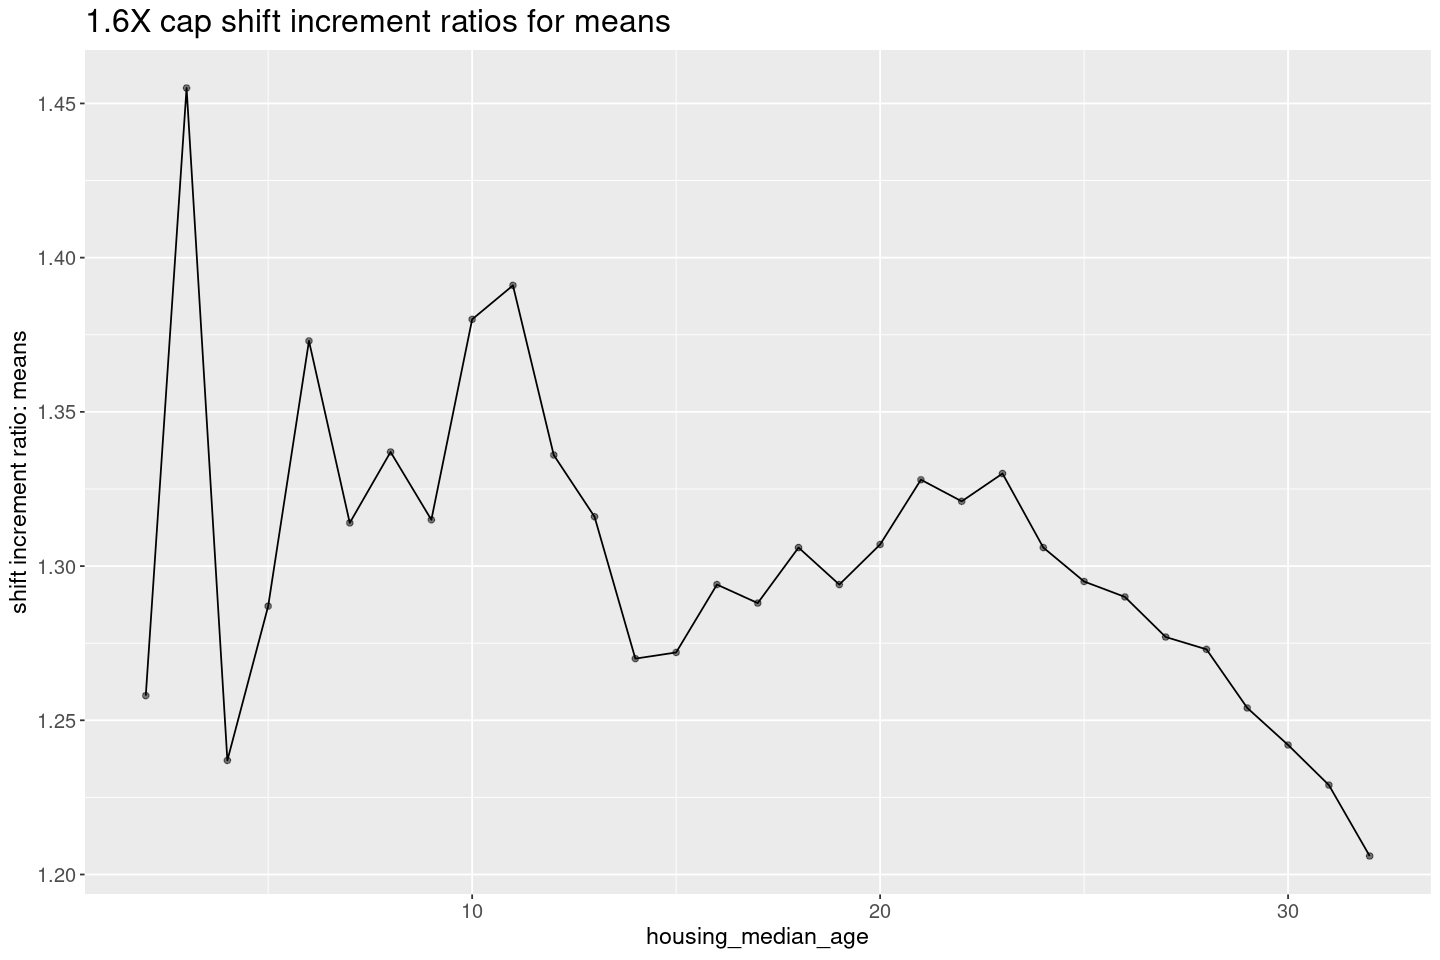

In [31]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(age, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("shift increment ratio: means") +
  geom_line() +
  ggtitle("1.6X cap shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENT:

# The plot for the means shows a strong downward trend when 
# the cap is >= 23.  The numbers strongly suggest that the 
# shift increment ratio for the range [52, 83] will be > 1
# and < 1.2.  The mean can never be < 1.

# The shift increment ratio for age 32 is 1.206.  The corres-
# ponding ratio for age 52 will almost certainly be < 1.2 due
# to the downward trend.  Notice that 1.2 * 52 = 62.4.  As 
# already mentioned in the comments regarding the counts, a 
# mean > 61 seems implausible; this judgment is based on the
# example distribution (mydist).


In [32]:
# The above ratios are based on very different counts.  When
# modeling we will thus likely need to make use of weighted
# least squares.

df_ratios$rcds


[1]  120  495  593  782 1008 1101 1466 1673 2746 3749 3996 4669 4765 5278 5948
[16] 5670 5905 5811 6334 7171 7549 8547 8494 8689 8788 8523 8682 8454 8368 8162
[31] 7752

In [33]:
# Obtain a prediction for the mean when age = 52.

f01 <- lm(I(mean_ratio - 1) ~ I(age^2), data= df_ratios,
          weights= df_ratios$rcds)
ans <- summary(f01)
ans[[1]] <- ""; ans



Call:
""

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-3.838 -1.321 -0.417  1.324  3.608 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)  3.46e-01   1.07e-02   32.41  < 2e-16
I(age^2)    -1.04e-04   1.78e-05   -5.85  2.4e-06

Residual standard error: 2.03 on 29 degrees of freedom
Multiple R-squared:  0.541,	Adjusted R-squared:  0.525 
F-statistic: 34.2 on 1 and 29 DF,  p-value: 2.43e-06


In [34]:
ncvTest(f01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.16065, Df = 1, p = 0.689

In [35]:
residualPlots(f01, plot=FALSE)


           Test stat Pr(>|Test stat|)
I(age^2)       -4.37          0.00016
Tukey test     -1.61          0.10765


In [36]:
# Prediction for mean when age = 52.

newdat <- df_ratios[1, ]
newdat[1, ] <- c(52, 1268, rep(NA, 4))

ans <- predict.lm(f01, newdata= newdat, type= "response")
ans <- ans + 1; print(ans)
# 1.0648

# 1.065 * 52 = 55.4


     1 
1.0648 


In [ ]:
### COMMENTS:

# The lowest a ratio can be is 1.  Model f01 predicts a value of
# 1.065 for the shift increment ratio of the mean.  
# 1.065 * 52 = 55.4.

# 55.4 looks plausible.  While f01 takes into account the record
# count at each age level, the model does not take into account
# that we are predicting for the very end of the distribution
# (meaning, it does not take into account a long tail, short tail,
# etc.).  This, and the fact that we are predicting so far out to
# the right, means that it would be good to also consider some 
# other models.


### Compute a 1.6X shift increment ratio for median

We would like to also have a prediction for the median because the mean is not robust to outliers and I need to somewhat arbitrarily set an upper limit when I run the Gibbs sampler that will generate our imputed values.  The lower I can set the upper limit, the lower the standard errors for the imputed values.  In other words, the lower I can set the upper limit (up to a point, of course), the better chance I have of improving the accuracy of the predictions for the imputed values.  But the more I adjust the upper limit for the Gibbs sampler, the less we can rely on the predicted mean.  This is where the median can help us.  (As we will see, the Gibbs sampler yields a mean for the imputed values at around the halfway point between the lower and upper limits.  Here the lower limit is the cap---age 52.)



                                   * * * * *

In [9]:
paste0("These are the 1.6X shift increments for the medians: ")
names(median_ratios) <- as.character(2:32)
print(median_ratios)


[1] "These are the 1.6X shift increments for the medians: "

    2     3     4     5     6     7     8     9    10    11    12    13    14 
1.500 1.333 1.250 1.200 1.333 1.286 1.375 1.333 1.400 1.455 1.333 1.308 1.214 
   15    16    17    18    19    20    21    22    23    24    25    26    27 
1.267 1.250 1.294 1.333 1.316 1.300 1.333 1.318 1.348 1.333 1.320 1.308 1.296 
   28    29    30    31    32 
1.250 1.241 1.200 1.194 1.156 


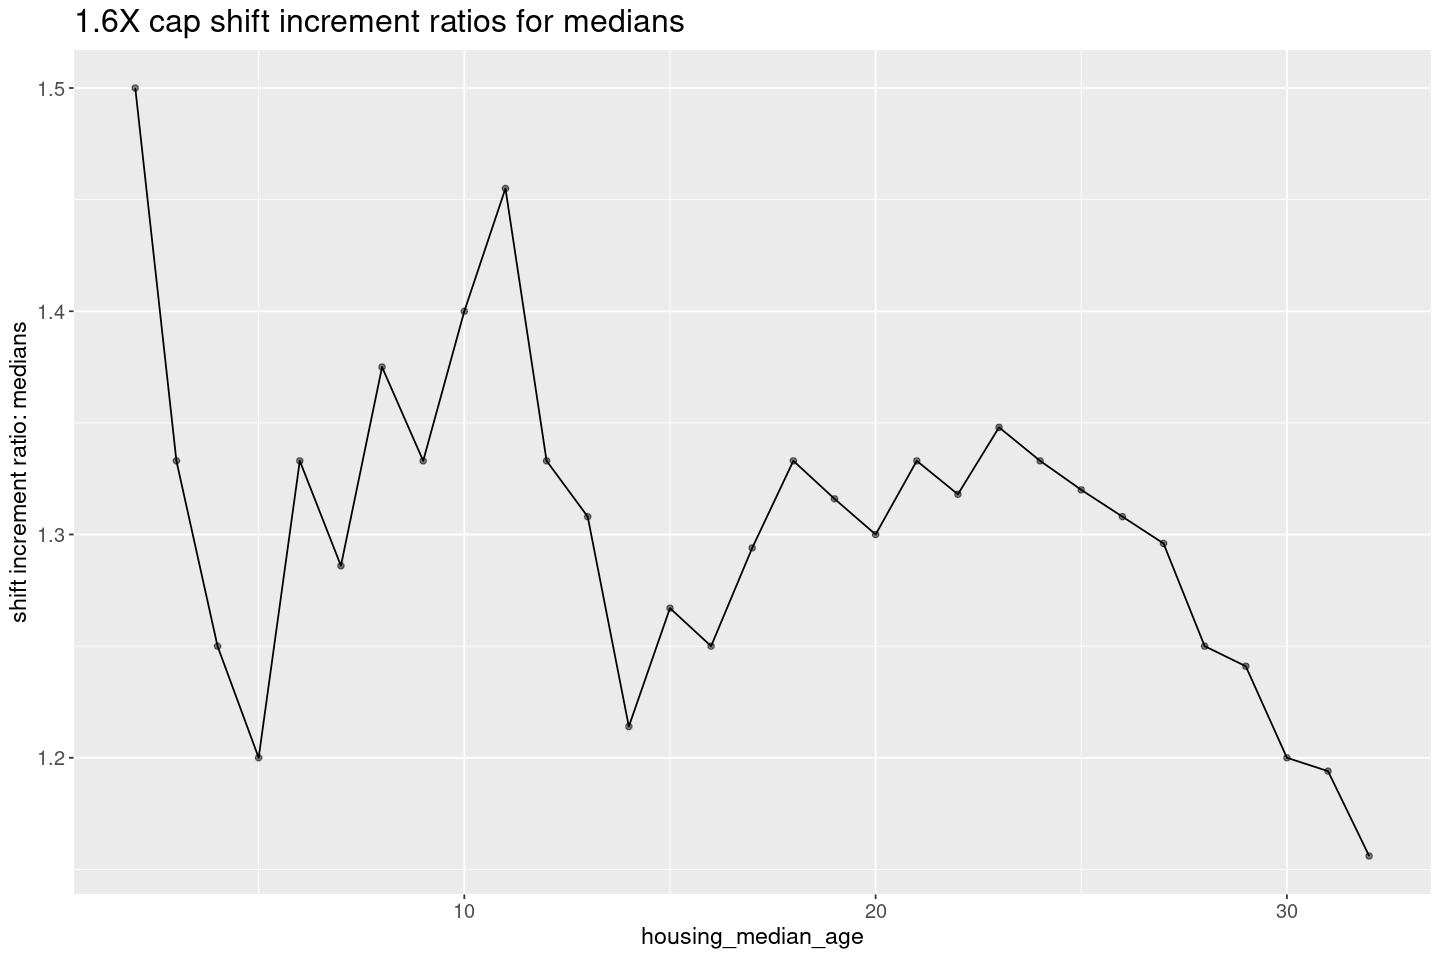

In [38]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(age, median_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("shift increment ratio: medians") +
  geom_line() +
  ggtitle("1.6X cap shift increment ratios for medians") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENT:

# Like the plot for the means, the plot for the median ratios
# has a strong downward trend when the cap is >= 23.  The 
# numbers strongly suggest that the shift increment ratio for
# the range [52, 83] will be > 1 and < 1.15.  The median ratio
# can never be < 1.

# Note that 1.15 * 52 = 59.8 < 60.  This is important when we
# consider the plausibility of the prediction below, using the
# g03 model.  In the comments on the distribution of counts (Figure 3),
# I mention that I would find a median > 59 to be implausible.
# The 59.8 number just computed is found using the shift increment
# ratio from age 32, which is 1.156.  The MEAN shift increment 
# ratio for age 32 is 1.206.  Again, 1.2 * 52 = 62.4 and 
# 1.15 * 52 = 59.8.  Notice that 59.8 is less than 62.4; we expect
# the median of our distribution of imputed values to be slightly
# less than the mean.  We have this relationship if we were to 
# simply use the ratios from age 32.


In [109]:
# Try to get a prediction for median for age = 52.

f02 <- lm(median_ratio ~ I(age^2), 
          data= df_ratios,
          weights= df_ratios$rcds)
ans <- summary(f02)
ans[[1]] <- ""; ans



Call:
""

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-8.187 -2.402 -0.417  2.461  6.877 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)  1.358964   0.019188   70.83  < 2e-16
I(age^2)    -0.000134   0.000032   -4.21  0.00023

Residual standard error: 3.64 on 29 degrees of freedom
Multiple R-squared:  0.379,	Adjusted R-squared:  0.358 
F-statistic: 17.7 on 1 and 29 DF,  p-value: 0.000227


In [110]:
ncvTest(f02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.16314, Df = 1, p = 0.686

In [111]:
# The linearity is not easy to fix for this model.

residualPlots(f02, plot=FALSE)


           Test stat Pr(>|Test stat|)
I(age^2)       -5.22          1.5e-05
Tukey test     -2.05            0.041


In [113]:
# Prediction for median when age = 52.

newdat <- df_ratios[1, ]
newdat[1, ] <- c(52, 1268, rep(NA, 4))

(ans <- predict.lm(f02, newdata= newdat, type= "response"))
# 0.9953


1 
0.99527

In [ ]:
### COMMENT:

# The f02 model does not help us get a meaningful
# prediction.  The model has a very low R-squared and 
# does not appear to satisfy the requirement of being
# linear with respect to the fitted values.  The pre-
# dicted value must be > 1.  If we simply use 1, our 
# median is at 52.  While this is certainly possible, 
# I am inclined to think the median is > 53.


### Look at the differences between the means and medians when span = 1.6X

We might have better luck predicting this difference rather than directly trying to predict the median.

In [53]:
df_ratios$delta <- df_ratios$mean - df_ratios$median
summary(df_ratios$delta)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.6988 -0.4138  0.0363  0.0759  0.3616  1.5882 

In [54]:
# Create dataframe for plotting.

tmpdat <- df_ratios
tmpdat$delta <- tmpdat$delta + 1


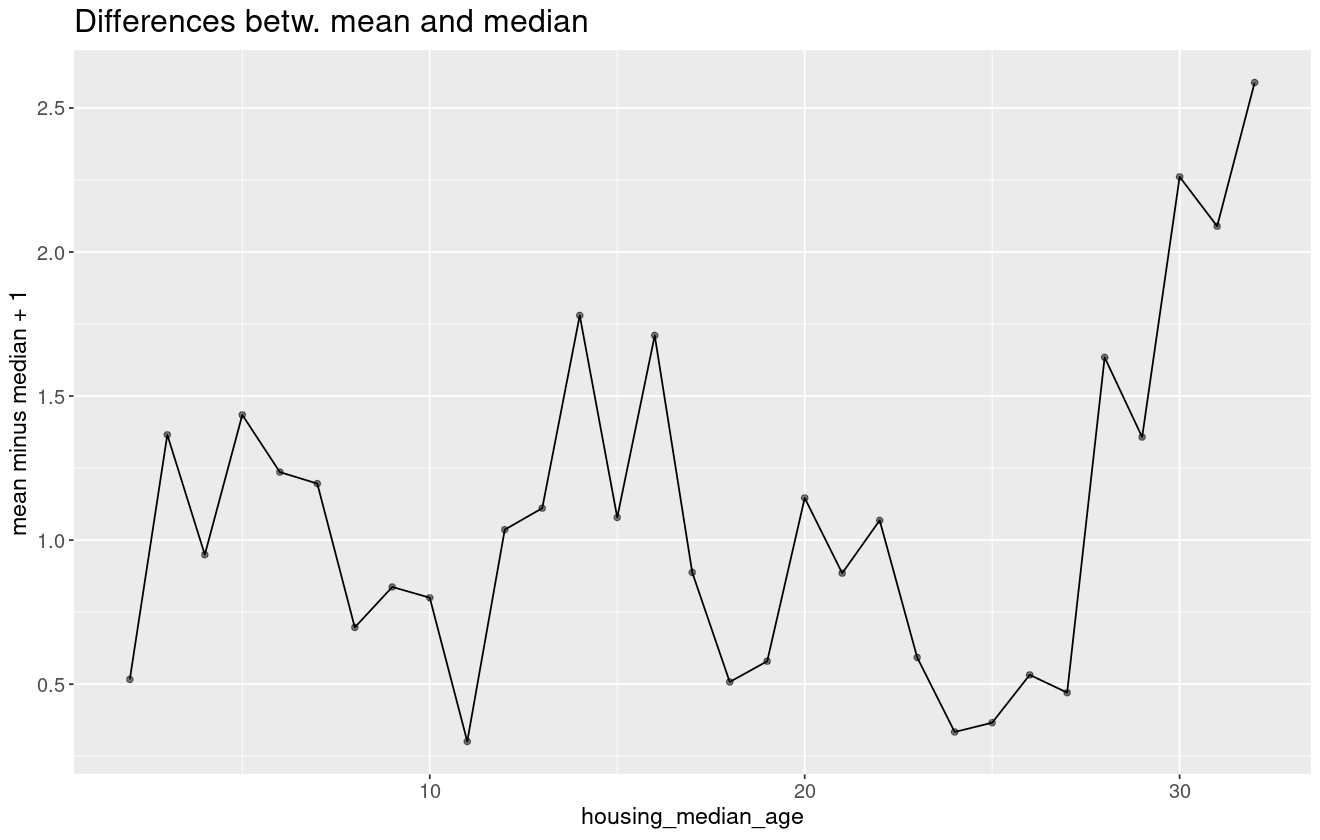

In [59]:
options(repr.plot.width= 11, repr.plot.height= 7)

p <- ggplot(tmpdat, aes(age, delta)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("mean minus median + 1") +
  geom_line() +
  ggtitle("Differences betw. mean and median") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENT:

# There is no clear trend in the plot; lots of variability exists.
# As age increases we would expect an upward trend due to
# the 1.6 multiplier.  I see no point in trying to model this
# difference as the response variable.



### Use 31-year span for computing shift-increment ratios

Repeat much of the above, but instead of looking out 1.6X the age level, add 31 years to each age level.  Note that 31 + 52 = 1.6 * 52 = 83.  I am initially using 83 as an upper limit for predicted imputed values.

In [114]:
# Get means and medians of the age values, 
# looking out 31 years. 

mean_ratios <- median_ratios <- rep(NA, length(2:20))
means <- medians <- rep(NA, length(2:20))
rcd_count <- rep(NA, length(2:20))

span <- 31
for(cur_age in 2:20) {
    
    agevals <- as.numeric(dat[which((dat$housing_median_age >= cur_age) &
                        (dat$housing_median_age <= round(span + cur_age))),
                  c("housing_median_age")])
    counts <- as.numeric(table(as.factor(agevals)))
    rcd_count[cur_age - 1] <- sum(counts)
    
    # Compute mean.
    age_mean <- round(mean(agevals), 5)
    mean_ratios[cur_age - 1] <- round(age_mean/cur_age, 3)
    means[cur_age - 1] <- age_mean

    # Compute median.
    age_median <- round(median(agevals), 5)
    median_ratios[cur_age - 1] <- round(age_median/cur_age, 3)
    medians[cur_age - 1] <- age_median
}

paste0("These are the 31-year shift increments for the means: ")
names(mean_ratios) <- as.character(2:20)
print(mean_ratios)


df_rat02 <- rep(NA, 6*length(mean_ratios))
dim(df_rat02) <- c(length(mean_ratios), 6)
df_rat02 <- as.data.frame(df_rat02)
colnames(df_rat02) <- c("age", "rcds","mean","median","mean_ratio","median_ratio")
df_rat02$age <- 2:20
df_rat02$rcds <- rcd_count
df_rat02$mean_ratio <- mean_ratios
df_rat02$median_ratio <- median_ratios
df_rat02$mean <- means
df_rat02$median <- medians


[1] "These are the 31-year shift increments for the means: "

     2      3      4      5      6      7      8      9     10     11     12 
10.320  7.136  5.570  4.662  4.015  3.519  3.147  2.854  2.619  2.439  2.286 
    13     14     15     16     17     18     19     20 
 2.156  2.045  1.951  1.873  1.817  1.763  1.709  1.652 


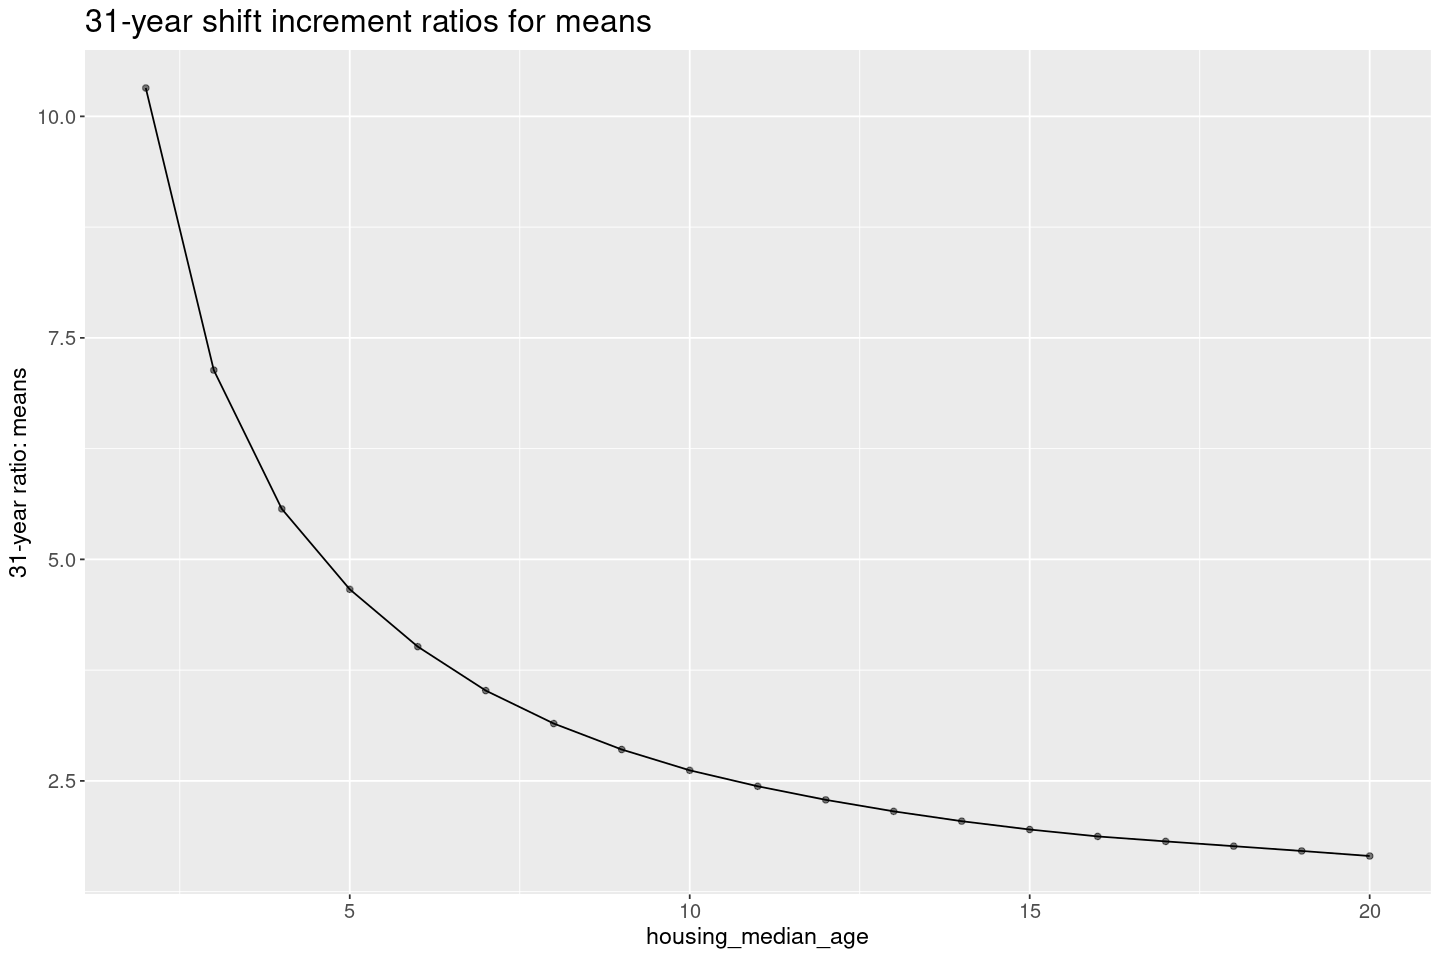

In [44]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_rat02, aes(age, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("31-year ratio: means") +
  geom_line() +
  ggtitle("31-year shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [45]:
# There is very little variance in the counts for ages 2-20.

df_rat02$rcds


[1] 12758 13388 14150 14819 15113 15346 15540 15640 15730 15834 15934 16051
[13] 16041 15873 15559 14970 14407 13973 13521

In [46]:
# Model for predicting mean_ratio at age = 52.

g02 <- lm(I(mean_ratio^0.33) ~ I(log(age)) + I((log(age))^2) , 
          data= df_rat02)
ans <- summary(g02)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-0.006064 -0.002727 -0.000101  0.002574  0.006407 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)      2.63352    0.00722   365.0   <2e-16
I(log(age))     -0.74605    0.00779   -95.8   <2e-16
I((log(age))^2)  0.08686    0.00196    44.2   <2e-16

Residual standard error: 0.00364 on 16 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 4.97e+04 on 2 and 16 DF,  p-value: <2e-16


In [47]:
ncvTest(g02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 1.4449, Df = 1, p = 0.229

In [48]:
residualPlots(g02, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(log(age))          1.16             0.26
I((log(age))^2)      1.13             0.27
Tukey test          -0.65             0.51


In [49]:
# Prediction for mean when age = 52.

newdat <- df_rat02[1, ]
newdat[1, ] <- c(52, rep(NA, 5))

ans <- predict.lm(g02, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.33); ans_transf
# 1.132

# 1.132 * 52 = 58.86


1 
1.1319

In [ ]:
### COMMENTS:

# g02 appears to be a much better model than f01 for predicting
# the shift increment for the mean.  However, unlike f01, it 
# does not take into account the number of records in each 
# interval.  Neither model knows where the age cut-off is.

# Note that the counts for df_rat02$rcds are all above 12K.  But 
# the interval for which we are predicting has only 1268 records.
# This might make a difference for the prediction.  That said,
# we have a very reasonable prediction: 1.132 * 52 = 58.86.

# From the sample distribution (mydist), we had a mean of 57.7.
# From model f01, the predicted mean was 55.4.  Because the data
# for g02 is so much easier to model than that for f01, there is
# reason to place much more confidence in the g02 prediction.


# While there may be a few districts with an age > 83---
# something that should increase our estimate of the mean---,
# I am inclined to believe that the counts will drop even
# more sharply than what we see in Figure 3.
# A sharper drop-off would push the mean lower than the 57.7
# that is the mean of the mydist counts.  Perhaps the mean
# should be around 57.  But g02 has just given us a prediction
# closer to 59.  So let's say, for the moment, that we should
# expect to see a mean around 57.5 or even 58.

# Tentative working mean for [52, 83] = 57.5.


In [115]:
# Model for predicting mean_ratio at age = 52 if we were
# to know the median for age 52.

g02b <- lm(I(mean_ratio^0.16) ~ median + I(log(age)) + I((log(age))^2) , 
          data= df_rat02)
ans <- summary(g02b)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-0.001986 -0.000720  0.000224  0.000675  0.001348 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)      1.551835   0.009653  160.75  < 2e-16
median           0.002708   0.000419    6.46  1.1e-05
I(log(age))     -0.237935   0.002454  -96.94  < 2e-16
I((log(age))^2)  0.017195   0.001014   16.96  3.4e-11

Residual standard error: 0.00101 on 15 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 6.33e+04 on 3 and 15 DF,  p-value: <2e-16


In [116]:
ncvTest(g02b)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.11253, Df = 1, p = 0.737

In [117]:
residualPlots(g02b, plot=FALSE)


                Test stat Pr(>|Test stat|)
median               1.20             0.25
I(log(age))         -0.90             0.38
I((log(age))^2)      0.40             0.69
Tukey test          -0.04             0.97


In [53]:
# g02b is a better model than g02, measured by AIC, 
# but we cannot use it because we do not yet have a
# prediction for the median.  (Still, it is worth 
# looking at for several reasons.  E.g., we could 
# use an analogous model when predicting the median.)

AIC(g02, g02b)


,df,AIC
,<dbl>,<dbl>
g02,4,-154.72
g02b,5,-202.68


In [259]:
# The negative numbers for AIC can be confusing, so it is
# worth taking a direct look at the log-likelihood.

logLik(g02)
logLik(g02b)


'log Lik.' 81.361 (df=4)

'log Lik.' 106.34 (df=5)

In [55]:
# Prediction for mean when age = 52 and median = 52.5.

newdat <- df_rat02[1, ]
newdat[1, ] <- c(52, NA, NA, 52.5, rep(NA, 2))

ans <- predict.lm(g02b, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.16); ans_transf
# 1.148 when median = 52.5

# 1.148 * 52 = 59.7

# The prediction is high!  g02 yields a more plausible prediction.


1 
1.1481

In [121]:
# How do we explain the supposedly better model 
# having the less plausible prediction?  (We 
# cannot go much lower than 52.5 for the median.)

# The predictors of g02b are highly correlated.  Thus,
# g02 is actually the better model.  Fortunately, g02
# also gives us a more plausible prediction.

round(cor(df_rat02$median, df_rat02$age), 4)


[1] 0.9925

### Compute a 31-year shift increment ratio for median

In [56]:
paste0("These are the 31-year shift increments for the medians: ")
names(median_ratios) <- as.character(2:20)
print(median_ratios)


[1] "These are the 31-year shift increments for the medians: "

     2      3      4      5      6      7      8      9     10     11     12 
10.500  7.333  5.750  4.800  4.167  3.571  3.250  2.889  2.600  2.455  2.333 
    13     14     15     16     17     18     19     20 
 2.154  2.071  2.000  1.875  1.824  1.778  1.737  1.650 


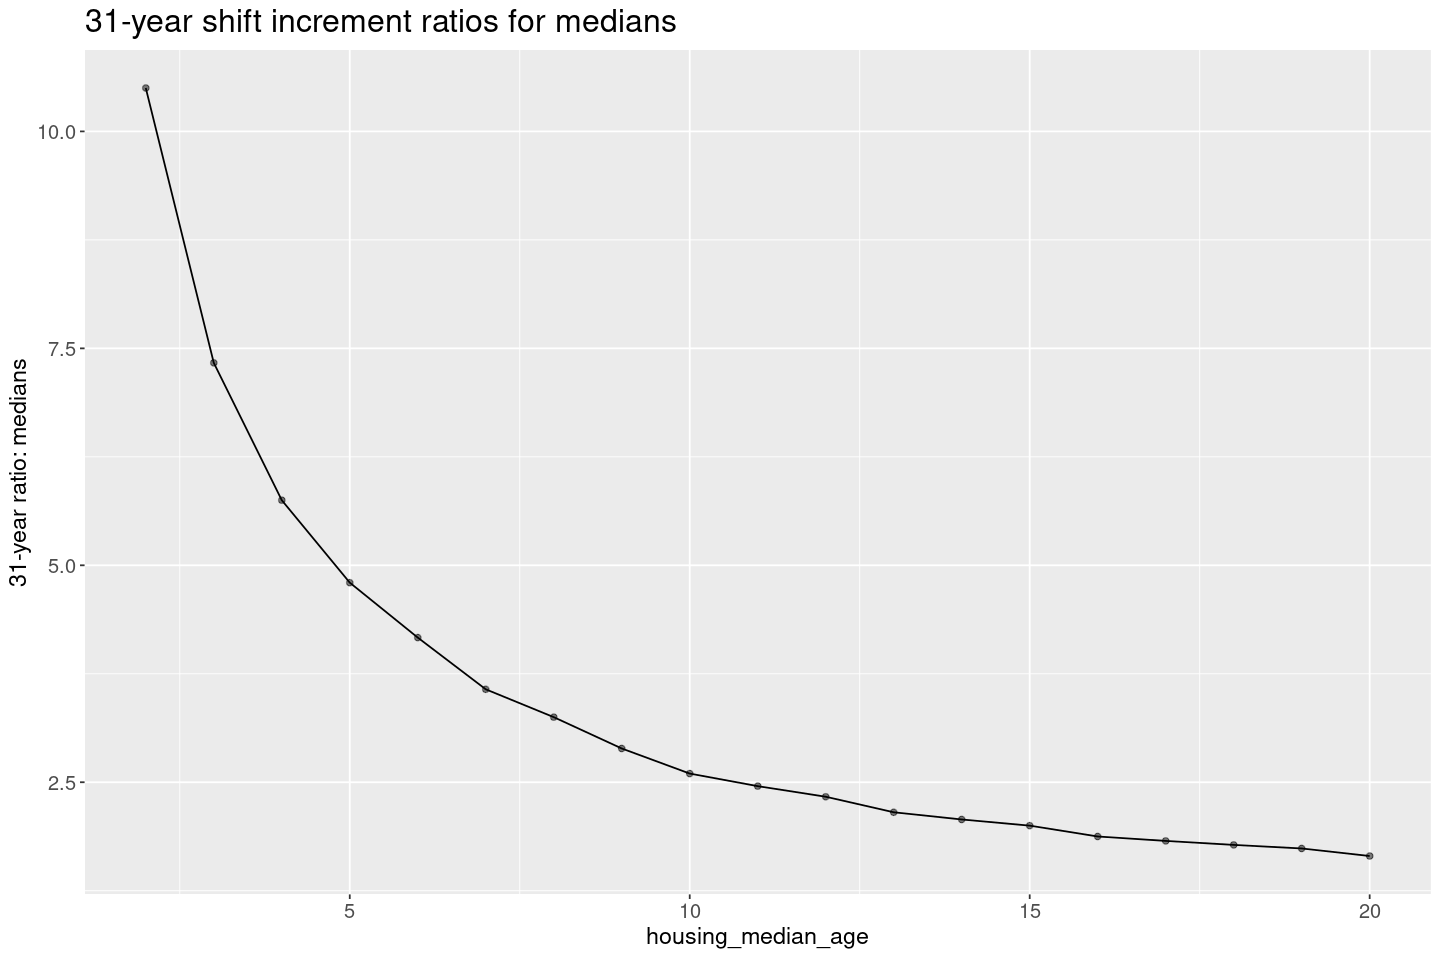

In [57]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_rat02, aes(age, median_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("31-year ratio: medians") +
  geom_line() +
  ggtitle("31-year shift increment ratios for medians") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p

# Compared to the previous curve based on means, the following
# curve for the medians is less smooth.  This has to do with
# the way the medians are computed.  It is also what likely makes
# it much more difficult to get good model predictions for the
# median.


In [58]:
# Model for predicting median_ratio at age = 52.

g03 <- lm(I(median_ratio^0.47) ~ I(log(age)) + I((log(age))^2) , 
          data= df_rat02)
ans <- summary(g03)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-0.019266 -0.006292 -0.000595  0.006023  0.020723 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)      3.92832    0.02042   192.3  < 2e-16
I(log(age))     -1.44667    0.02205   -65.6  < 2e-16
I((log(age))^2)  0.18652    0.00556    33.6  2.9e-16

Residual standard error: 0.0103 on 16 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 1.95e+04 on 2 and 16 DF,  p-value: <2e-16


In [59]:
ncvTest(g03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.26829, Df = 1, p = 0.604

In [60]:
residualPlots(g03, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(log(age))         -0.47             0.65
I((log(age))^2)      0.65             0.52
Tukey test          -0.37             0.71


In [61]:
# Prediction for median when age = 52.

newdat <- df_rat02[1, ]
newdat[1, ] <- c(52, rep(NA, 5))

ans <- predict.lm(g03, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.47); ans_transf
# 1.283

# 1.283 * 52 = 66.7  (i.e., we cannot trust g03 at all!)


1 
1.2828

In [ ]:
### COMMENTS:

# 1.283 * 52 = 66.7.  This prediction is not plausible.
# We expect the median to be less than the mean since
# the median is not affected by outliers.  Also, I would
# think that a solid majority of the ages (90%?) would be
# at or below 67.  The median for mydist was 57, and our
# current working estimate for the mean is 57.5.

# We saw above that at age 32 the 1.6X span shift increment
# for the median is 1.156.  This value, and the strong 
# downward trajectory we see in the corresponding plot, 
# suggest that the median for the range [52, 83] will be
# less than 1.15 * 52 = 59.8.

# Since our working estimate for the mean is 57.5, I would
# expect the median to be around 56.5 or 57.


### Look at the differences between the means and medians when span = 31 years

In [68]:
df_rat02$delta <- df_rat02$mean - df_rat02$median
summary(df_rat02$delta)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.911  -0.642  -0.366  -0.384  -0.140   0.191 

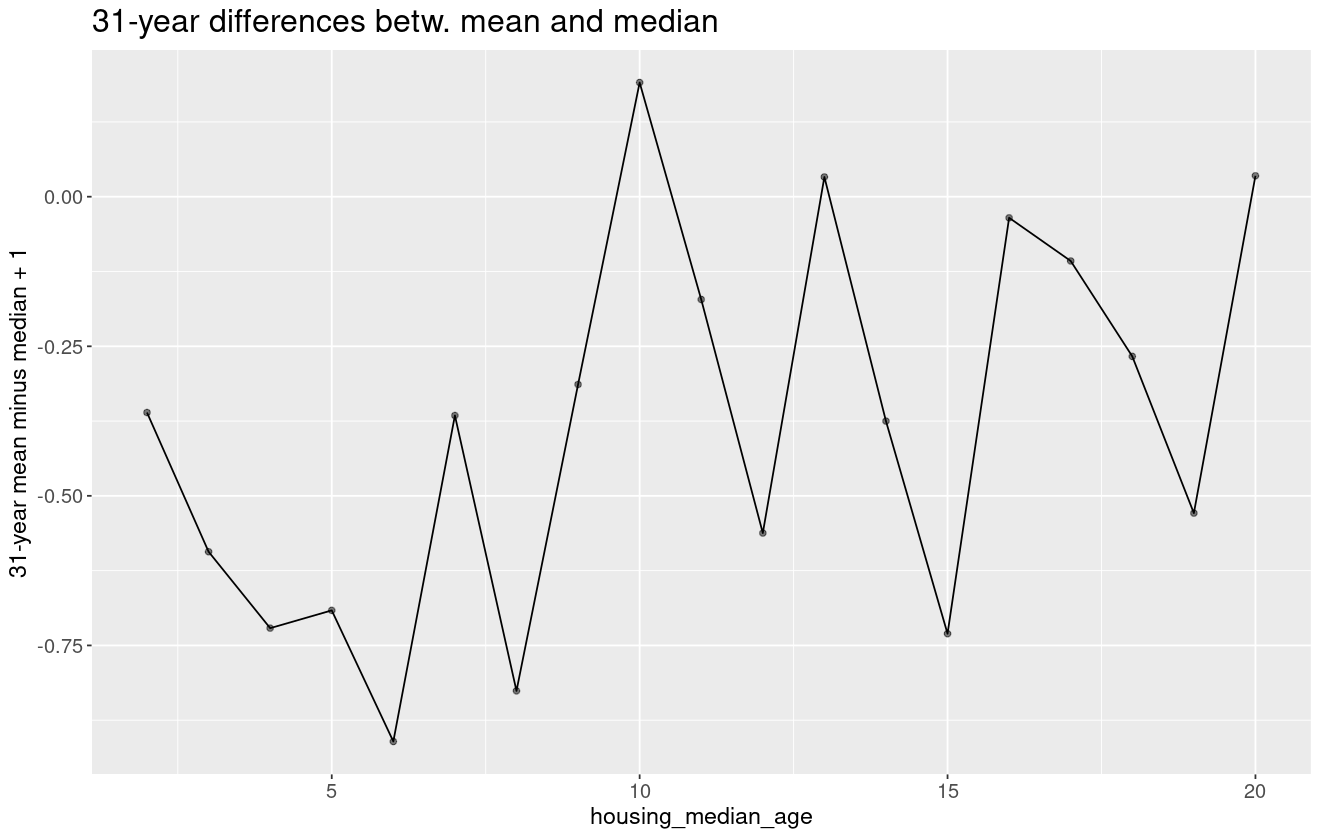

In [72]:
options(repr.plot.width= 11, repr.plot.height= 7)

p <- ggplot(df_rat02, aes(age, delta)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("31-year mean minus median + 1") +
  geom_line() +
  ggtitle("31-year differences betw. mean and median") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENT:

# Figure 1 shows us why the median is almost always greater
# than the mean in the 31-year data. Counts do not begin to 
# significantly drop off until age is at 36; and then it takes
# a while before the drop is enough to show up in the 31-year
# measurements.  31-year measurements starting at age 36 should
# nearly all have a median that is less than the mean.  This is
# a consequence of the general shape of the distribution of counts.


### Get predictions for mean and median using 15-year window

If we look again at Figures 2 and 3, it is reasonable to expect nearly all districts with a housing median age over 51 to have an age <= 67.  But this means we can perhaps get a clearer idea of where the mean lies by looking out only 15 years instead of 31.

In [119]:
# Get means and medians of the age values, 
# looking out 15 years.  The window actually 
# includes 16 years of data.

mean_ratios <- median_ratios <- rep(NA, length(2:36))
means <- medians <- rep(NA, length(2:36))
rcd_count <- rep(NA, length(2:36))

span <- 15
for(cur_age in 2:36) {
    
    agevals <- as.numeric(dat[which((dat$housing_median_age >= cur_age) &
                        (dat$housing_median_age <= round(span + cur_age))),
                  c("housing_median_age")])
    counts <- as.numeric(table(as.factor(agevals)))
    rcd_count[cur_age - 1] <- sum(counts)
    
    # Compute mean.
    age_mean <- round(mean(agevals), 5)
    mean_ratios[cur_age - 1] <- round(age_mean/cur_age, 3)
    means[cur_age - 1] <- age_mean

    # Compute median.
    age_median <- round(median(agevals), 5)
    median_ratios[cur_age - 1] <- round(age_median/cur_age, 3)
    medians[cur_age - 1] <- age_median
}

paste0("These are the 15-year shift increments for the means: ")
names(mean_ratios) <- as.character(2:36)
print(mean_ratios)


df_rat03 <- rep(NA, 6*length(mean_ratios))
dim(df_rat03) <- c(length(mean_ratios), 6)
df_rat03 <- as.data.frame(df_rat03)
colnames(df_rat03) <- c("age", "rcds","mean","median","mean_ratio","median_ratio")
df_rat03$age <- 2:36
df_rat03$rcds <- rcd_count
df_rat03$mean_ratio <- mean_ratios
df_rat03$median_ratio <- median_ratios
df_rat03$mean <- means
df_rat03$median <- medians


[1] "These are the 15-year shift increments for the means: "

    2     3     4     5     6     7     8     9    10    11    12    13    14 
6.085 4.305 3.389 2.873 2.535 2.266 2.072 1.926 1.816 1.734 1.652 1.579 1.519 
   15    16    17    18    19    20    21    22    23    24    25    26    27 
1.475 1.441 1.432 1.425 1.415 1.407 1.397 1.373 1.344 1.319 1.295 1.275 1.263 
   28    29    30    31    32    33    34    35    36 
1.247 1.233 1.216 1.200 1.183 1.170 1.158 1.150 1.145 


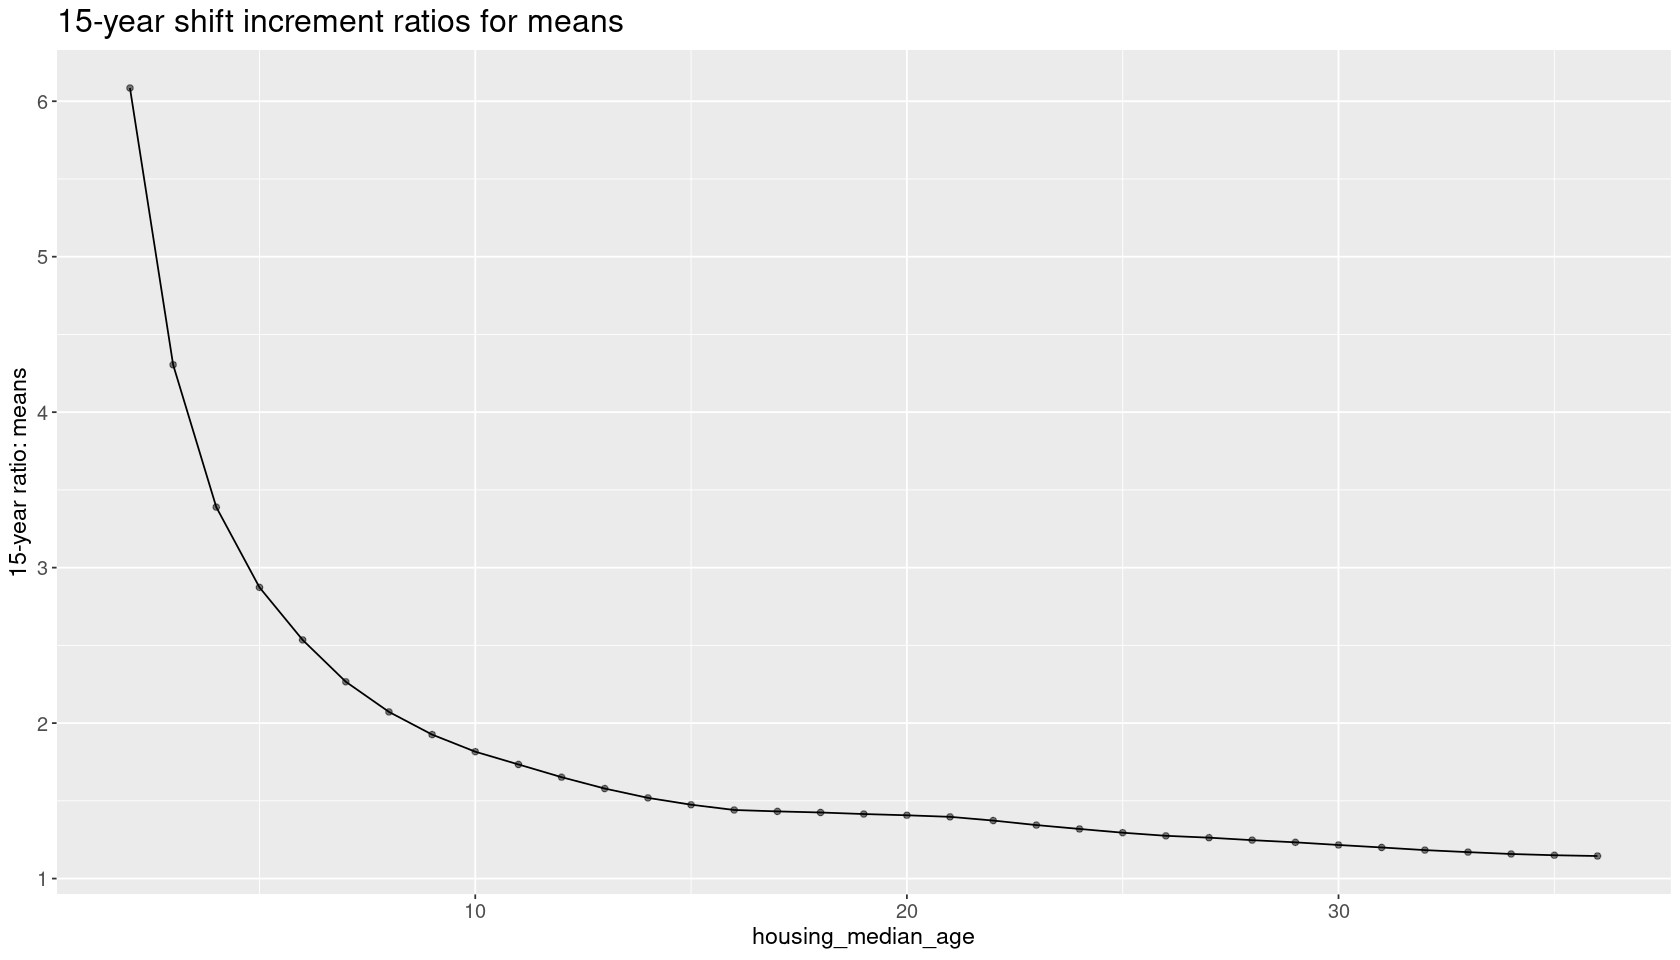

In [22]:
options(repr.plot.width= 14, repr.plot.height= 8)

p <- ggplot(df_rat03, aes(age, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("15-year ratio: means") +
  geom_line() +
  ggtitle("15-year shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [23]:
round(sd(df_rat03$rcds), 1)


[1] 1190

In [71]:
# Model for predicting mean_ratio at age = 52.

h02 <- lm(I(mean_ratio^0.47) ~ I(age^-0.225) + I((age^-0.225)^2) , 
          data= df_rat03)
ans <- summary(h02)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-0.015825 -0.008005 -0.000569  0.007019  0.022548 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)
(Intercept)          1.746      0.059    29.6   <2e-16
I(age^-0.225)       -3.890      0.197   -19.8   <2e-16
I((age^-0.225)^2)    5.360      0.159    33.7   <2e-16

Residual standard error: 0.0111 on 32 degrees of freedom
Multiple R-squared:  0.999,	Adjusted R-squared:  0.998 
F-statistic: 1.07e+04 on 2 and 32 DF,  p-value: <2e-16


In [72]:
ncvTest(h02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 1.5399, Df = 1, p = 0.215

In [73]:
residualPlots(h02, plot=FALSE)


                  Test stat Pr(>|Test stat|)
I(age^-0.225)         -0.71             0.48
I((age^-0.225)^2)      0.11             0.91
Tukey test            -0.06             0.95


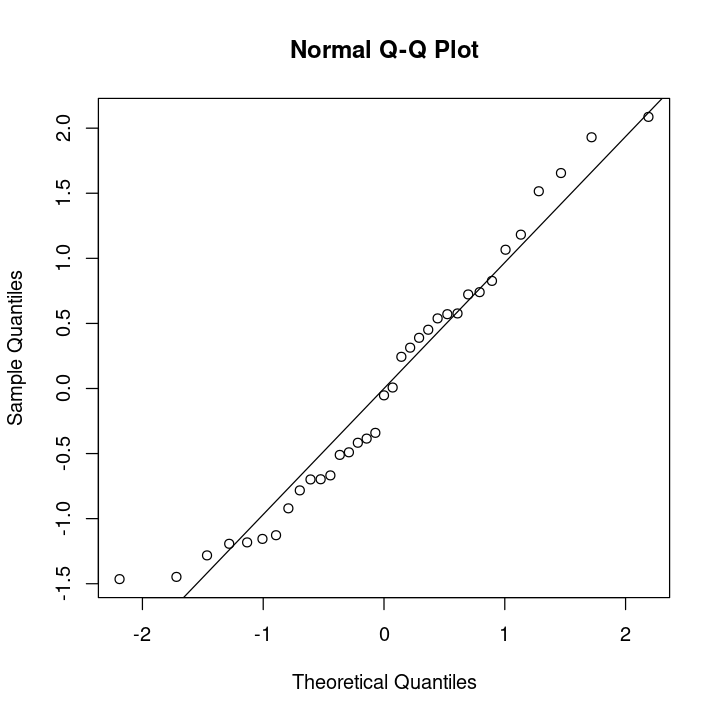

In [75]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(h02, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [74]:
# Prediction for mean when age = 52.

newdat <- df_rat03[1, ]
newdat[1, ] <- c(52, rep(NA, 5))

ans <- predict.lm(h02, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.47); ans_transf
# 1.116

# 1.116 * 52 = 58.0  (This prediction, in my view, is
# better than what we saw from g02.)


1 
1.1164

In [ ]:
### COMMENTS:

# 1.116 * 52 = 58.0.  As with all of the above models, 
# except for f01, h02 does not take into account the
# drop-off in counts.  If I add the counts as weights,
# the model prediction is less plausible.

# The g02 model predicted a mean of 58.86.  So it appears
# that the h02 model gives us a better prediction.  If h02
# and g02 were able to take into account the sharp drop-off
# in records, the predicted means would be a bit smaller.


### Do we get a better prediction for the median with the 15-year increments?

In [193]:
paste0("These are the 15-year shift increments for the medians: ")
names(median_ratios) <- as.character(2:36)
print(median_ratios)


[1] "These are the 15-year shift increments for the medians: "

    2     3     4     5     6     7     8     9    10    11    12    13    14 
7.000 4.667 3.750 3.200 2.667 2.286 2.125 1.889 1.800 1.727 1.583 1.538 1.500 
   15    16    17    18    19    20    21    22    23    24    25    26    27 
1.467 1.438 1.471 1.444 1.421 1.400 1.429 1.409 1.391 1.333 1.320 1.308 1.259 
   28    29    30    31    32    33    34    35    36 
1.250 1.207 1.200 1.161 1.156 1.121 1.118 1.114 1.139 


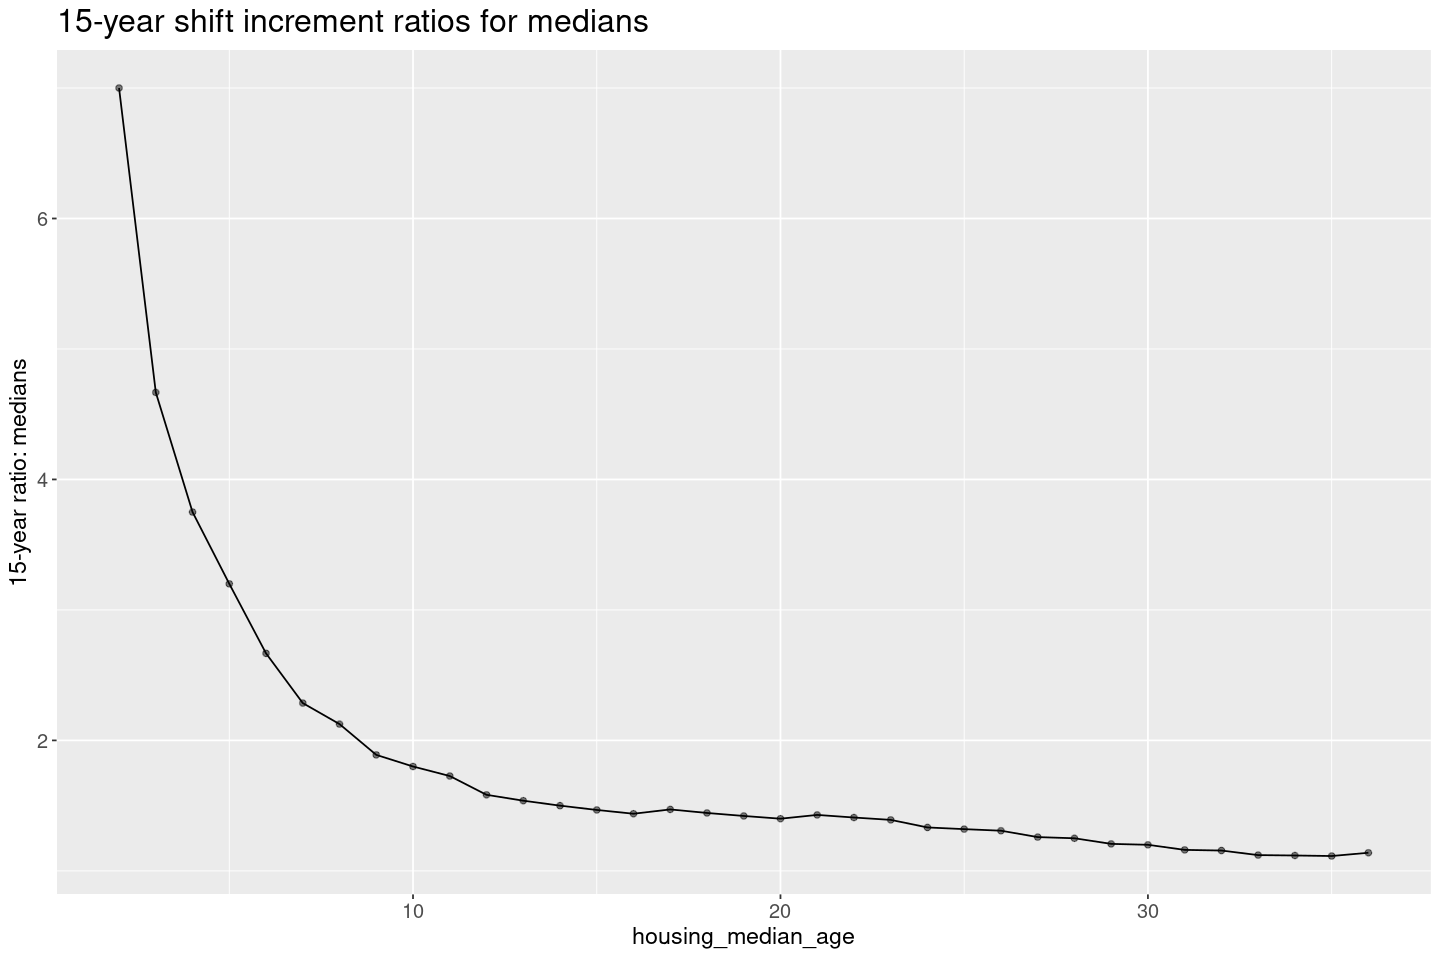

In [194]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_rat03, aes(age, median_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("15-year ratio: medians") +
  geom_line() +
  ggtitle("15-year shift increment ratios for medians") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p

# Again, the curve is not nearly as smooth as the curve for
# the means.


In [198]:
# Model for predicting median_ratio at age = 52.

h03 <- lm(I(median_ratio^0.47) ~ I(age^-0.2) + I((age^-0.2)^2) , 
          data= df_rat03)
ans <- summary(h03)
ans[[1]] <- ""; ans



Call:
""

Residuals:
     Min       1Q   Median       3Q      Max 
-0.03575 -0.01833 -0.00443  0.02003  0.04225 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)        2.595      0.164    15.8  < 2e-16
I(age^-0.2)       -6.931      0.517   -13.4  1.1e-14
I((age^-0.2)^2)    7.831      0.398    19.7  < 2e-16

Residual standard error: 0.0244 on 32 degrees of freedom
Multiple R-squared:  0.994,	Adjusted R-squared:  0.994 
F-statistic: 2.8e+03 on 2 and 32 DF,  p-value: <2e-16


In [199]:
ncvTest(h03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.24627, Df = 1, p = 0.62

In [200]:
residualPlots(h03, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(age^-0.2)          0.95             0.35
I((age^-0.2)^2)      0.63             0.53
Tukey test           0.40             0.69


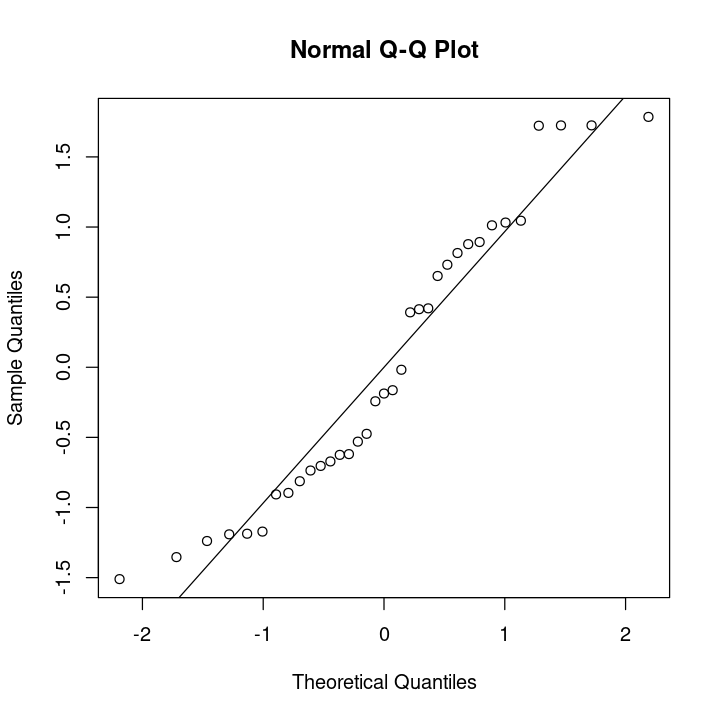

In [250]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(h03, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [201]:
# Prediction for median when age = 52.

newdat <- df_rat03[1, ]
newdat[1, ] <- c(52, rep(NA, 5))

ans <- predict.lm(h03, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.47); ans_transf
# 1.137

# Notice that this prediction is larger than the shift-increment
# ratio for year 35 (1.114), but between ages 35 and 50, there
# is the very sharp drop in counts; the drop is so sharp, that
# I would not expect this rate of decrease to be matched for
# our 1268 records.

# 1.137 * 52 = 59.1


1 
1.1371

In [ ]:
### COMMENTS:

# With the 31-year window, our prediction for the median was
# 66.7.  The new model, h03, yields a much more plausible 
# prediction of 59 years.
# Still, Figure 3 and mydist suggest a median of 57.  We have 
# reason to believe a good prediction for the mean is at 57.5. 
# And we expect the median will be smaller than the mean at 
# this end of the distribution of age counts.  Like h02, h03
# does not take into the account the sharp drop in the number
# of districts with ages > 51.  So there is still reason to 
# believe our median could be closer to 57 than to 59.


In [ ]:
#&* Bookmark

## Final Comments for Section 1

For the imputation process that follows, getting good predictions for the median and mean is crucial.  From the above we can be fairly confident that the mean of the true, unobserved district ages is <= 60 and the median is <= 59.  We can be fairly confident that the median will be less than the mean.  The mean is likely to be between 55 and 60; our current working prediction is that the mean is **57.5**.  The median is likely to be between 53 and 59; our current working prediction is that the median is **56.5 or 57**.

The sharp drop-off in counts is what pulls both the mean and median in closer to the cap of 52.

Note that my working prediction for the median is *not* independent of the prediction for the mean; the former relies very much on what we have observed about the latter and the fact that we are fairly certain that in the range \[52, 83\] the median will be less than the mean.  The model predictions for the mean appear more accurate than those for the median.  For the mean, f01 predicted 55.4; my example scenario (Figure 3) predicted 57.7; g02 predicted 58.9; and h02 predicted 58.0.  There is reason to trust h02 more than g02 and h02 more than f01.  h02's prediction is very close to what we see with the example scenario (Figure 3).  But h02 does not fully take into account the sharp drop in counts, whereas Figure 3 does to a degree.  Since I think for the true, unobserved values the shape of the distribution in Figure 3 will need to be more compressed (toward a shape similar to the right-hand side of a normal distribution), I am predicting a mean of 57.5 rather than 58.  That's the argument anyway.  And the median is predicted to be 56.5 - 57 because we expect it to be less than the mean in this region of the distribution of age counts.  Our best model prediction thus far for the median, by contrast, is at 59.




                                      * * * * *

# Section 2: Impute values for censored ages

This section complements the material in Section 2 of Part01.



In [ ]:
# Continue to use dat from Section 1 above.  6.15% of the
# records in dat have a censored housing median age.


In [4]:
colnames(dat)
summary(dat$housing_median_age)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    28.6    37.0    52.0 

In [5]:
# This is the model from Section 2, Part01 that we want 
# to use for imputing age values.

a03 <- lm(housing_median_age ~ 

            I(long_transf^-1) +
            I(long_transf^-1.5) +
          
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
          
            I(households^0.55) +
            I(households^1.1) +
          
            I(median_house_value^0.48) +
            I(median_house_value^0.24) +
          
            I(HHdens_ln^1.35) +
            I(HHdens_ln^2.7),
          
          data= dat, weights= dat$households^0.55)

## REMINDER: dat has censored housing_median_age values.

a03.summary <- summary(a03); 
a03.summary[[1]] <- ""; a03.summary



Call:
""

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-229.00  -36.97    1.64   35.26  239.57 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)
(Intercept)                -8.92e+04   5.71e+03   -15.6   <2e-16
I(long_transf^-1)           4.43e+02   1.78e+01    24.9   <2e-16
I(long_transf^-1.5)        -4.93e+02   2.13e+01   -23.1   <2e-16
latitude                    9.73e+03   6.28e+02    15.5   <2e-16
I(latitude^2)              -3.97e+02   2.59e+01   -15.3   <2e-16
I(latitude^3)               7.19e+00   4.73e-01    15.2   <2e-16
I(latitude^4)              -4.88e-02   3.23e-03   -15.1   <2e-16
I(households^0.55)         -6.26e-01   1.96e-02   -31.9   <2e-16
I(households^1.1)           2.73e-03   2.15e-04    12.7   <2e-16
I(median_house_value^0.48)  2.69e-01   1.05e-02    25.7   <2e-16
I(median_house_value^0.24) -1.04e+01   3.97e-01   -26.2   <2e-16
I(HHdens_ln^1.35)          -9.87e-01   7.66e-02   -12.9   <2e-16
I(HHdens_ln^2.7)           

In [6]:
ncvTest(a03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.13688, Df = 1, p = 0.711

In [7]:
residualPlots(a03, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(long_transf^-1)              -6.43          1.3e-10
I(long_transf^-1.5)            -6.53          6.7e-11
latitude                      -10.83          < 2e-16
I(latitude^2)                  -9.83          < 2e-16
I(latitude^3)                  -8.94          < 2e-16
I(latitude^4)                  -8.36          < 2e-16
I(households^0.55)             -8.07          7.2e-16
I(households^1.1)               5.08          3.8e-07
I(median_house_value^0.48)     -5.82          5.9e-09
I(median_house_value^0.24)     -7.61          2.8e-14
I(HHdens_ln^1.35)               7.57          3.8e-14
I(HHdens_ln^2.7)                5.70          1.2e-08
Tukey test                      0.05             0.96


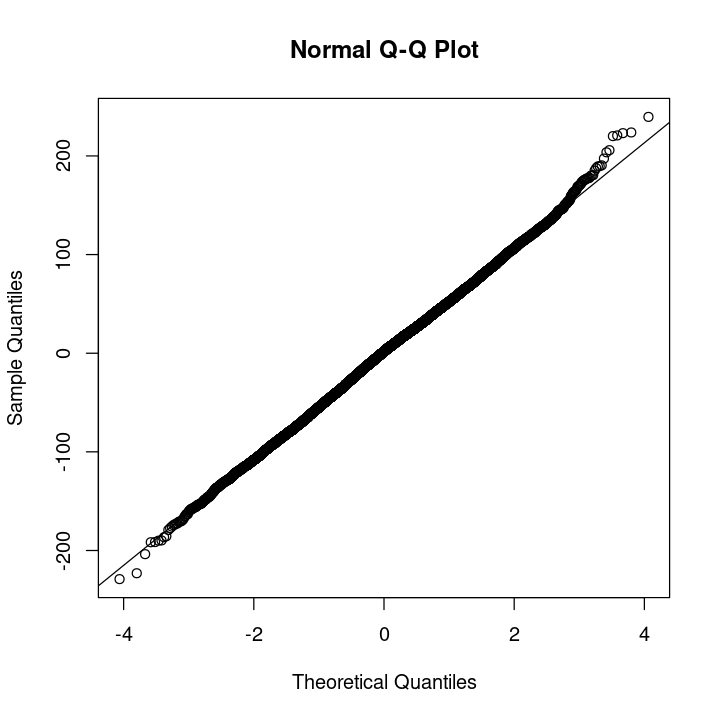

In [8]:
options(repr.plot.width= 6, repr.plot.height= 6)

qqnorm(residuals(a03, type= "pearson"))
qqline(residuals(a03, type= "pearson"))


In [9]:
# The value we assign to the upper limit is important.  The
# aim is to have an imputation range that captures most of
# the ages we would expect to find.  If we expand the range 
# too much, the quality of the imputed values (measured in
# terms of how close, on average, they are to the actual
# values) will decrease.  The mean of the predictions from
# the Gibbs sampler will be about halfway between the lower limit
# and the upper limit.  With 78 as the upper limit, the mean
# should be around age 65.

C <- 52
censored <- dat$housing_median_age >= C

# Create an upper limit.
C_upper <- 78

# Create some crude starting values for our imputed ages.
n.censored <- sum(censored)
z <- ifelse(censored, NA, dat$housing_median_age)
z[censored] <- runif(n.censored, C, C_upper)


In [10]:
length(censored)
n.censored


[1] 20603

[1] 1268

In [11]:
# Function to draw from a constrained normal distribution.

rnorm.trunc <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need mu to be at least the value of C in
    # order to prevent a return of Inf values.
    mu02 <- ifelse(mu < C, C, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [12]:
# Create matrix X for the terms in our model.

X <- dat

X$long1 <- (X$long_transf)^-1
X$long2 <- (X$long_transf)^-1.5

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$hh1 <- (X$households)^0.55
X$hh2 <- (X$households)^1.10

X$median_hhval_1 <- (X$median_house_value)^0.24
X$median_hhval_2 <- (X$median_house_value)^0.48

X$HHdens_ln1 <- (X$HHdens_ln)^1.35
X$HHdens_ln2 <- (X$HHdens_ln)^2.7


X <- X[, c("long1","long2","latitude","lat2","lat3","lat4",
           "hh1","hh2","median_hhval_1","median_hhval_2",
           "HHdens_ln1","HHdens_ln2")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 20603    13

[1] "intercept"      "long1"          "long2"          "latitude"      
 [5] "lat2"           "lat3"           "lat4"           "hh1"           
 [9] "hh2"            "median_hhval_1" "median_hhval_2" "HHdens_ln1"    
[13] "HHdens_ln2"

In [ ]:
# The Gibbs Sampler.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

sims <- array(NA, c(n.iter, n.chains, 14 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        a03.1 <- lm(z ~ 
                    
            I(long_transf^-1) +
            I(long_transf^-1.5) +
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
            I(households^0.55) +
            I(households^1.1) +
            I(median_house_value^0.48) +
            I(median_house_value^0.24) +
            I(HHdens_ln^1.35) +
            I(HHdens_ln^2.7),
          
            data= dat, weights= dat$households^0.55)
        
        sim.1 <- sim(a03.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.6 mins (for 2K iterations)


In [ ]:
# We check for convergence as follows:

sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [ ]:
str(sims.bugs)

# Output for this cell has been removed because it
# interferes with the output of cells further downstream.


In [ ]:
save(sims, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_age.RData")


In [13]:
load("/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_age.RData")


In [14]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 1282

In [15]:
# Check that the means and stddevs for the parameters and 
# imputed values does not include the burn-in values.

sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [16]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 64.60 64.73 64.89 64.76 64.91 65.03

[1] 7.47 7.60 7.42 7.47 7.39 7.48

In [17]:
summary(z_means)
summary(z_sds)

# Notice that the minimum stddev is 7.3 years. and
# that the average stddev is close to 7.5 years.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   64.4    64.7    64.8    64.8    64.9    65.2 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7.31    7.44    7.48    7.48    7.51    7.64 

In [ ]:
### COMMENTS:

# From the work in Section 1 above, we expect the mean for the
# censored records to be about 57.5, not 65.  I can adjust for this
# by subtracting 8 from each prediction.  


In [18]:
# Get some predictions, using rnorm.trunc.

z_preds <- round(rnorm.trunc(n.censored, z_means, z_sds, lo=C, hi=C_upper), 1)
summary(z_preds)

# Notice that the mean and median of our predictions are around 65.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    60.5    65.0    64.9    69.4    77.9 

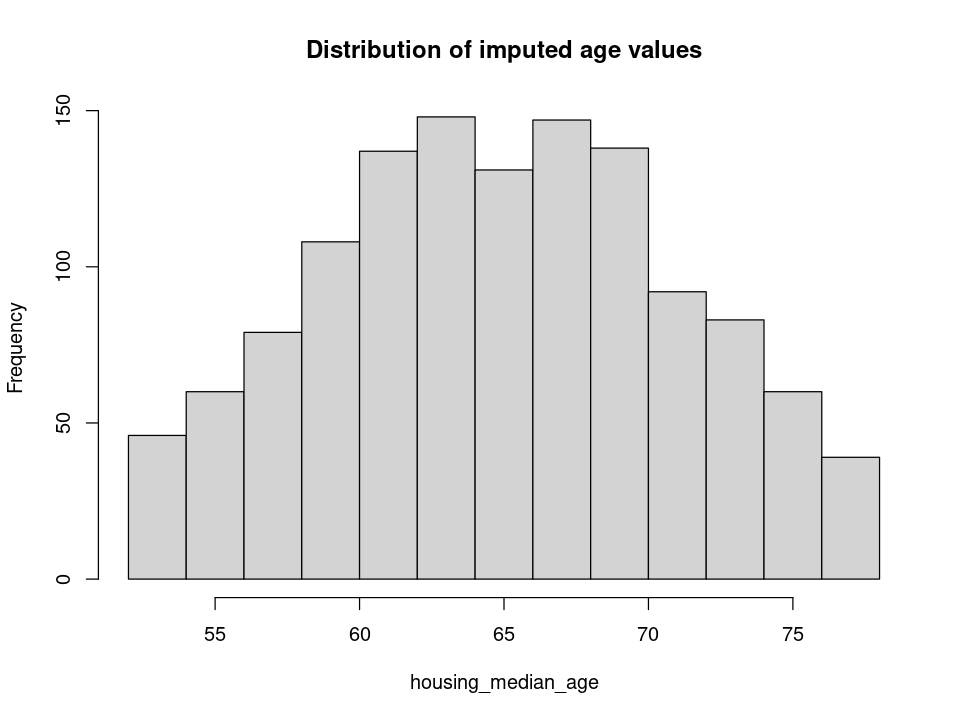

In [19]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=14, main="Distribution of imputed age values",
     xlab="housing_median_age")


In [ ]:
### COMMENTS:

# The above shape is not what we want for our imputed values
# (assuming we want our imputed values to have a distribution
# like the distribution we would expect the true, unobserved
# values to have). 


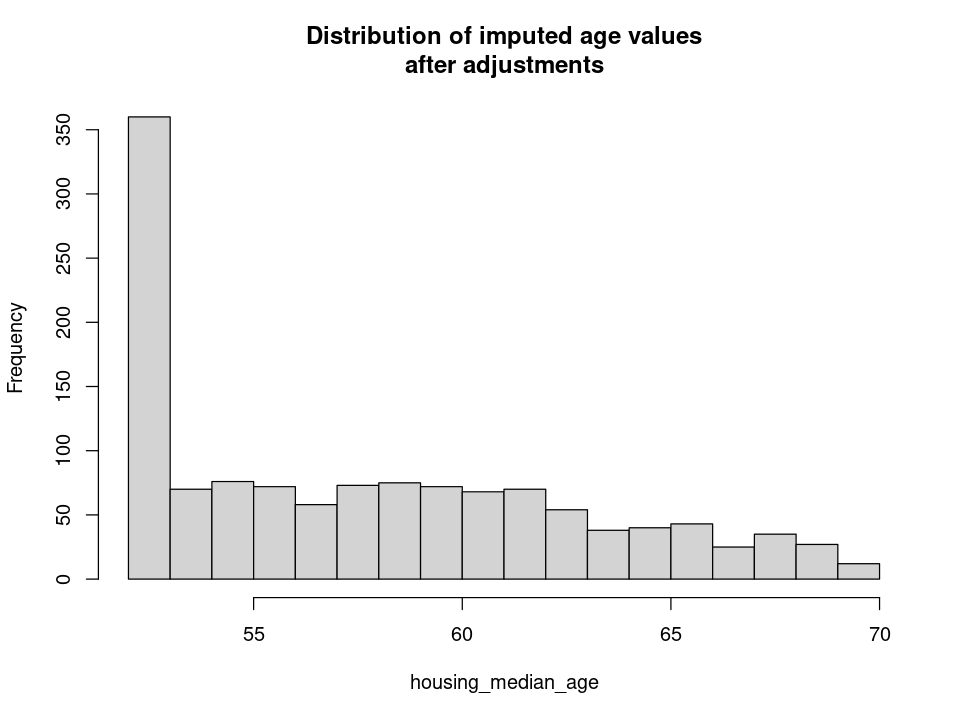

In [20]:
# Adjust the predictions based on what we learned in 
# Section 1.  We want the mean of our imputed values
# to be about 57-58.

z_preds <- z_preds - 8
preds_adj <- ifelse(z_preds < 52, 52, z_preds)

options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=14, main="Distribution of imputed age values
after adjustments",
     xlab="housing_median_age")


In [21]:
summary(preds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    52.5    57.0    57.7    61.4    69.9 

In [ ]:
### COMMENTS:

# While the mean and median are now where we expect them to
# be, we do not expect there to be a sudden drop in the number
# of districts as housing_median_age increases from 52 to 
# 53; we expect the drop, if there is one, to be more gradual; 

# We can fix this by adjusting z_means prior to 
# calling rnorm.trunc.


In [22]:
# The following provides us with a start.  The subtrahend
# used here will need to be adjusted once we see the truncated
# output from rnorm.trunc.

(z_means_bar <- mean(z_means))
z_means_adj <- z_means - (z_means_bar - 57)
mean(z_means_adj)


[1] 64.808

[1] 57

In [23]:
# Get new predictions.  I have lowered the upper limit from
# 78 to 75.

set.seed(1933)
z_preds <- round(rnorm.trunc(n.censored, z_means_adj, z_sds, lo=C, hi=75), 2)
summary(z_preds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    55.7    59.1    60.0    63.4    75.0 

In [24]:
# Make another correction.

z_means_adj <- z_means - (z_means_bar - 50)
mean(z_means_adj)

set.seed(1933)
z_preds <- round(rnorm.trunc(n.censored, z_means_adj, z_sds, lo=C, hi=75), 2)
summary(z_preds)
# The mean is now at about 58 and the median at 57.


[1] 50

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    54.3    56.8    57.9    60.5    74.9 

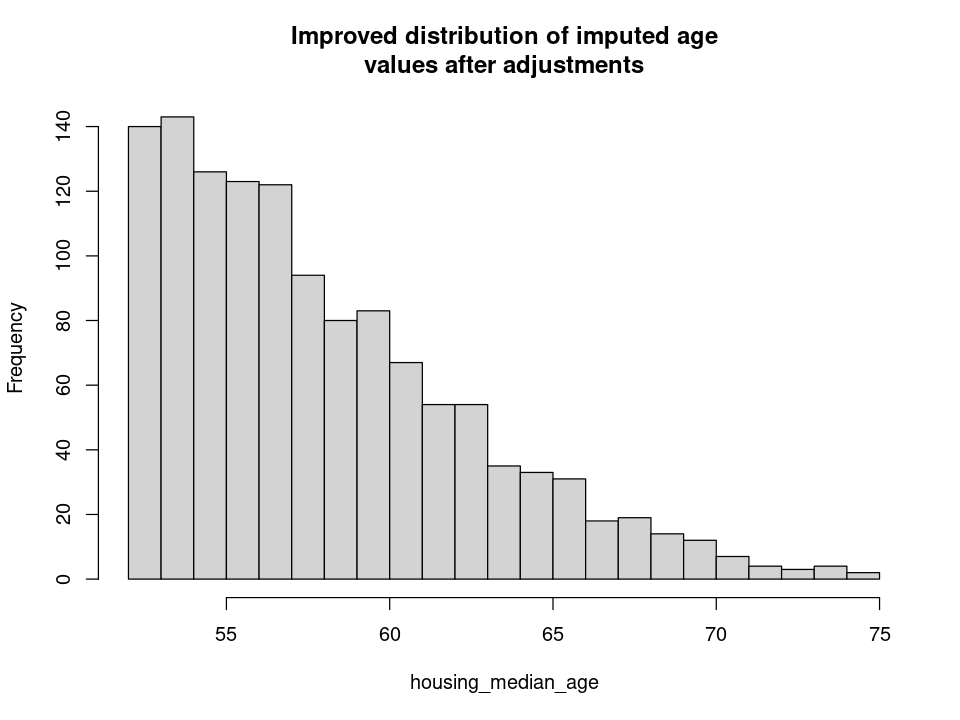

In [25]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, 
     main="Improved distribution of imputed age
values after adjustments", xlab="housing_median_age")


In [ ]:
### COMMENT:

# The shape of the above distribution is far more plausible
# than the previous distribution of predictions, which had
# around 30% of the predictions at age 52.  Also, we
# now have a mean of 58 for the imputed values rather than
# 65.  

# There is a trade-off with respect to setting the upper
# limit.  If I expand the range of ages in which my 
# predictions can lie beyond a certain point, the less 
# accurate the predictions will be, on average.  For the 
# current set of predictions, I now have an upper limit for
# age of 75 years.  There are likely to be a few districts 
# with an age > 75, but we know that the vast majority of 
# districts will have an age that lies in the range of 52-75.
# One might argue that I should be even more conservative with
# the upper limit, but the more I lower it, the closer the shape
# of the distribution comes to being uniform.  For present 
# purposes, we do not want such a shape.  

# When we compare the performance of different models, I will
# treat the imputed values as if they are true, observed values.
# Thus, I want the shape of the above distribution to be like the 
# shape we would expect to see from the true values.


In [26]:
# Assign imputed values.

newdat <- dat
newdat$housing_median_age[censored] <- z_preds


In [27]:
summary(newdat$housing_median_age)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    29.0    37.0    74.9 

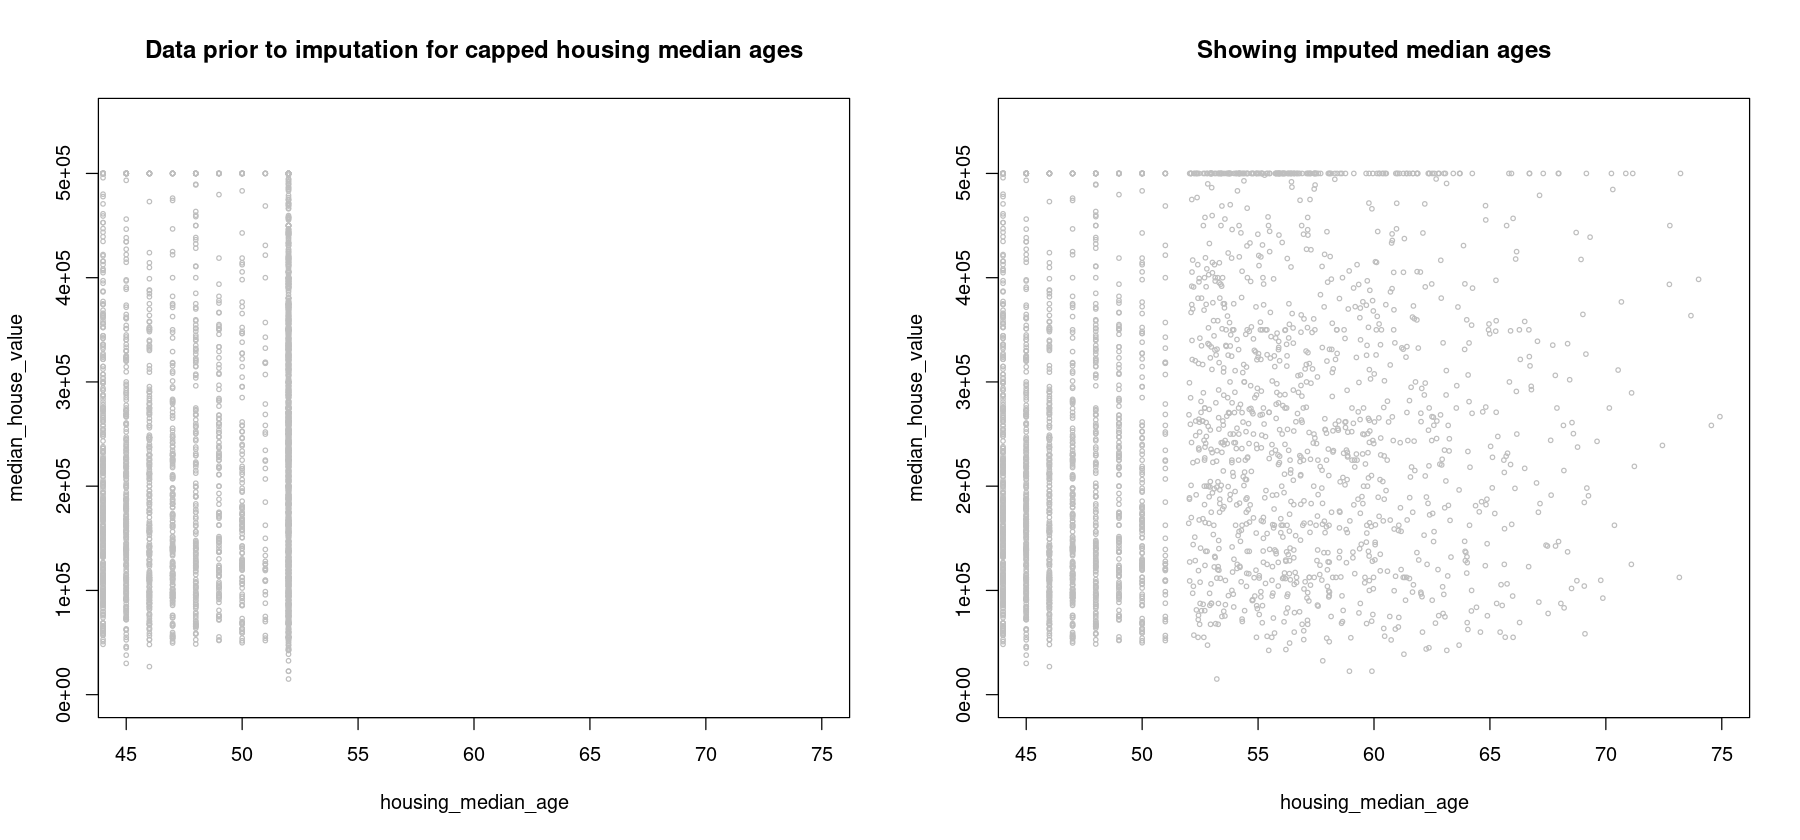

In [28]:
# Plot both before and after.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$housing_median_age, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Data prior to imputation for capped housing median ages")


# plot the newly predicted values
plot(newdat$housing_median_age, newdat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Showing imputed median ages")


### Save to disk

In [29]:
# Saving imputed values for housing_median_age to housing_cleaned_v03.csv.

write.csv(newdat,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03.csv",
          row.names=TRUE)


In [30]:
rm(newdat)


In [31]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat); colnames(dat)


[1] 20603    15

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

## Re-assess Section 1 predictions for mean and median

With the additional data, we can roll a 15-year window out to age 52 if we like.  But if we stop at age 45, even our last data point will be based mostly on observed data, and not the imputed values.  This will allow me to make a prediction for age 52 that is still mostly based on the observed data.  We can then see if the prediction agrees with the mean and medians we currently have at age 52.  If there is agreement, we can conclude that the imputed values are consistent with the observed data.

In [32]:
# Get means and medians of the age values, 
# looking out 15 years.  A span of 15 means that
# each window includes 16 years of data.

mean_ratios <- median_ratios <- rep(NA, length(2:52))
means <- medians <- rep(NA, length(2:52))
rcd_count <- rep(NA, length(2:52))

span <- 15
for(cur_age in 2:52) {
    
    agevals <- as.numeric(dat[which((dat$housing_median_age >= cur_age) &
                        (dat$housing_median_age <= round(span + cur_age))),
                  c("housing_median_age")])
    counts <- as.numeric(table(as.factor(agevals)))
    rcd_count[cur_age - 1] <- sum(counts)
    
    # Compute mean.
    age_mean <- round(mean(agevals), 5)
    mean_ratios[cur_age - 1] <- round(age_mean/cur_age, 3)
    means[cur_age - 1] <- age_mean

    # Compute median.
    age_median <- round(median(agevals), 5)
    median_ratios[cur_age - 1] <- round(age_median/cur_age, 3)
    medians[cur_age - 1] <- age_median
}

paste0("15-year shift increments for the means: ")
names(mean_ratios) <- as.character(2:52)
print(mean_ratios)


df_rat03 <- rep(NA, 6*length(mean_ratios))
dim(df_rat03) <- c(length(mean_ratios), 6)
df_rat03 <- as.data.frame(df_rat03)
colnames(df_rat03) <- c("age", "rcds","mean","median","mean_ratio","median_ratio")
df_rat03$age <- 2:52
df_rat03$rcds <- rcd_count
df_rat03$mean_ratio <- mean_ratios
df_rat03$median_ratio <- median_ratios
df_rat03$mean <- means
df_rat03$median <- medians


[1] "15-year shift increments for the means: "

    2     3     4     5     6     7     8     9    10    11    12    13    14 
6.085 4.305 3.389 2.873 2.535 2.266 2.072 1.926 1.816 1.734 1.652 1.579 1.519 
   15    16    17    18    19    20    21    22    23    24    25    26    27 
1.475 1.441 1.432 1.425 1.415 1.407 1.397 1.373 1.344 1.319 1.295 1.275 1.263 
   28    29    30    31    32    33    34    35    36    37    38    39    40 
1.247 1.233 1.216 1.200 1.183 1.170 1.158 1.150 1.145 1.143 1.142 1.138 1.135 
   41    42    43    44    45    46    47    48    49    50    51    52 
1.129 1.125 1.124 1.124 1.128 1.130 1.130 1.129 1.126 1.120 1.116 1.102 


In [58]:
# Compute the amount of observed data for the interval [45, 60]; 
# this is our last data point used in the model below.

total <- nrow(dat[which((dat$housing_median_age >= 45) & (dat$housing_median_age <= 60)),])
observed <- nrow(dat[which((dat$housing_median_age >= 45) & (dat$housing_median_age <= 51)),])
(percent_observed <- 100* round(observed/total, 3))
paste0("The percent of observed data remaining at age 45, for the 15-year window is: ", 
       as.character(percent_observed))


[1] 57.4

[1] "The percent of observed data remaining at age 45, for the 15-year window is: 57.4"

In [59]:
# Compute the amount of observed data for the interval [40, 55].
# Recall that the interval from [36, 51] has 100% observed data.

total <- nrow(dat[which((dat$housing_median_age >= 40) & (dat$housing_median_age <= 55)),])
observed <- nrow(dat[which((dat$housing_median_age >= 40) & (dat$housing_median_age <= 51)),])
(percent_observed <- 100* round(observed/total, 3))
paste0("The percent of observed data remaining at age 40, for the 15-year window is: ", 
       as.character(percent_observed))


[1] 87.7

[1] "The percent of observed data remaining at age 40, for the 15-year window is: 87.7"

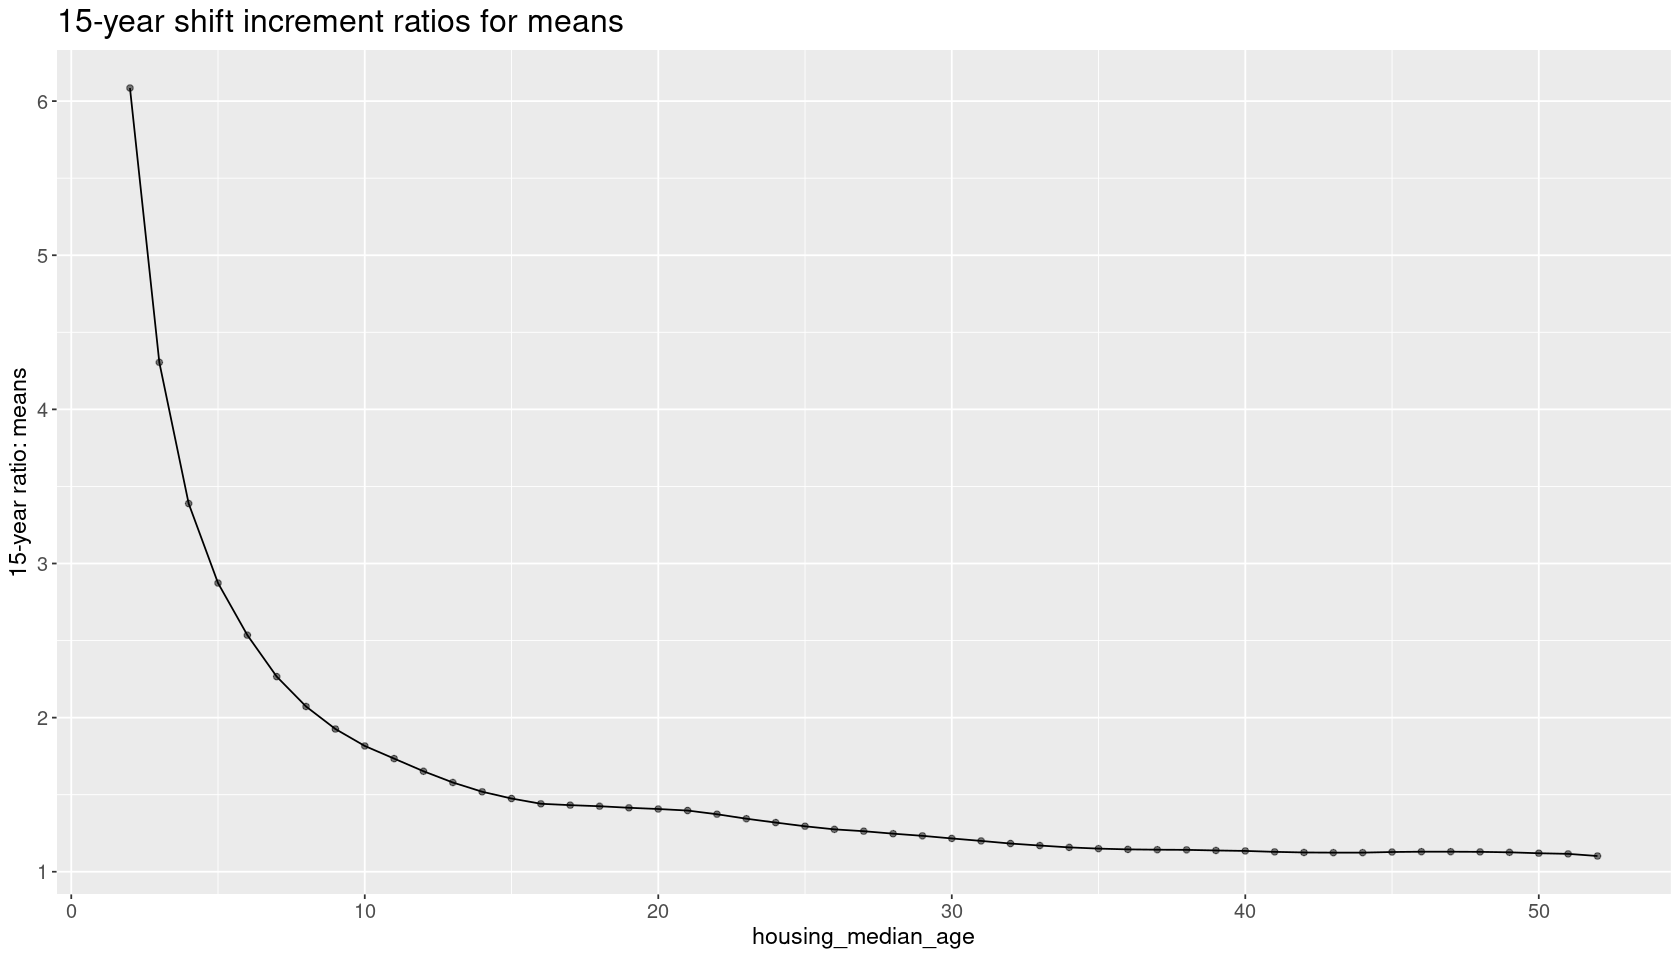

In [33]:
options(repr.plot.width= 14, repr.plot.height= 8)

p <- ggplot(df_rat03, aes(age, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("15-year ratio: means") +
  geom_line() +
  ggtitle("15-year shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [34]:
# The stddev has increased substantially.

round(sd(df_rat03$rcds), 1)


[1] 2603.5

In [36]:
df_rat04 <- df_rat03[which(df_rat03$age <= 45),]
dim(df_rat04)


[1] 44  6

In [60]:
tail(df_rat04$rcds)


[1] 3312 3131 2958 2684 2411 2139

In [52]:
# Model for predicting mean_ratio at age = 52.

p02 <- lm(I(mean_ratio^0.47) ~ I(age^-0.247) + I((age^-0.247)^2) , 
          data= df_rat04)
ans <- summary(p02)
ans[[1]] <- ""; ans



Call:
""

Residuals:
     Min       1Q   Median       3Q      Max 
-0.01679 -0.00677 -0.00256  0.00660  0.02277 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)
(Intercept)          1.455      0.035    41.6   <2e-16
I(age^-0.247)       -2.818      0.127   -22.2   <2e-16
I((age^-0.247)^2)    4.595      0.110    41.7   <2e-16

Residual standard error: 0.0101 on 41 degrees of freedom
Multiple R-squared:  0.999,	Adjusted R-squared:  0.999 
F-statistic: 1.48e+04 on 2 and 41 DF,  p-value: <2e-16


In [53]:
ncvTest(p02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.21575, Df = 1, p = 0.642

In [54]:
residualPlots(p02, plot=FALSE)


                  Test stat Pr(>|Test stat|)
I(age^-0.247)          0.19             0.85
I((age^-0.247)^2)      0.15             0.88
Tukey test             0.00             1.00


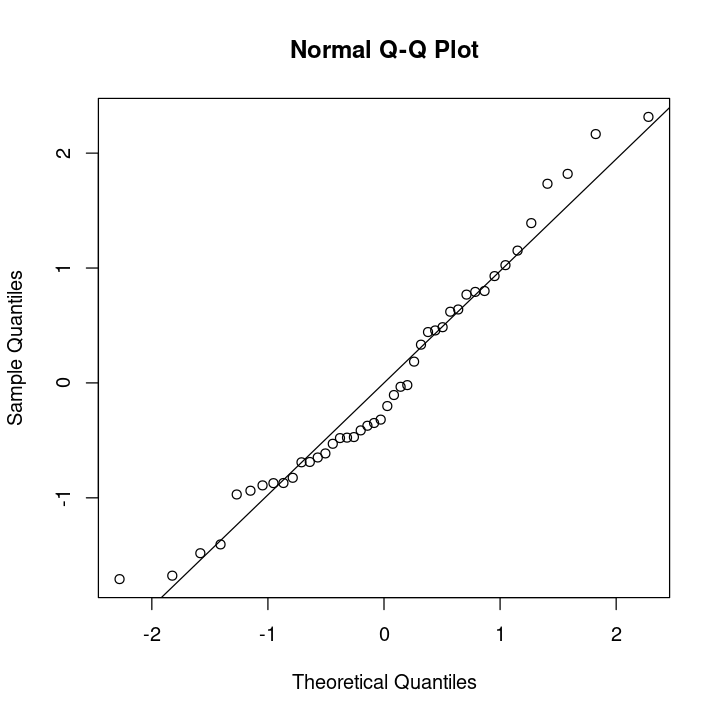

In [55]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(p02, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [56]:
# Prediction for mean when age = 52.

newdat <- df_rat04[1, ]
newdat[1, ] <- c(52, rep(NA, 5))

ans <- predict.lm(p02, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.47); ans_transf
# 1.099

# 1.099 * 52 = 57.1 

# The 95% CI is: [54.8, 59.5]


1 
1.0988

In [ ]:
### COMMENTS:

# At age 45 the 15-year window takes us out to age 59.  The
# shift-increment ratio for the mean at age 45 is based on
# 57% observed data and 43% imputed values.  But for the 
# interval [40, 55], the computed shift-increment is based
# on 88% observed and only 12% imputed.  In other words, the
# p02 model is not overly influenced by the imputed values.

# Using the predicted ratio of 1.099, the predicted mean at 
# age 52 is 57.1.  With the current set of imputed values, 
# the "actual" ratio at age 52 is 1.102.  1.102 * 52 = 57.3.  
# For ALL 1268 imputed values, the mean is at 57.9.  

# The actual mean is larger than 57.3 because the 1.102 shift
# increment is only for the interval [52, 67] and imputed 
# values go out to age 75.

# Unless we find something terribly out of line with the 
# prediction for the median that follows, I am satisfied that
# the current set of imputed values are consistent with the
# data.


In [72]:
paste0("15-year shift increments for the medians: ")
names(median_ratios) <- as.character(2:52)
print(median_ratios)


[1] "15-year shift increments for the medians: "

    2     3     4     5     6     7     8     9    10    11    12    13    14 
7.000 4.667 3.750 3.200 2.667 2.286 2.125 1.889 1.800 1.727 1.583 1.538 1.500 
   15    16    17    18    19    20    21    22    23    24    25    26    27 
1.467 1.438 1.471 1.444 1.421 1.400 1.429 1.409 1.391 1.333 1.320 1.308 1.259 
   28    29    30    31    32    33    34    35    36    37    38    39    40 
1.250 1.207 1.200 1.161 1.156 1.121 1.118 1.114 1.139 1.135 1.132 1.128 1.100 
   41    42    43    44    45    46    47    48    49    50    51    52 
1.098 1.095 1.093 1.091 1.111 1.134 1.132 1.127 1.121 1.113 1.103 1.087 


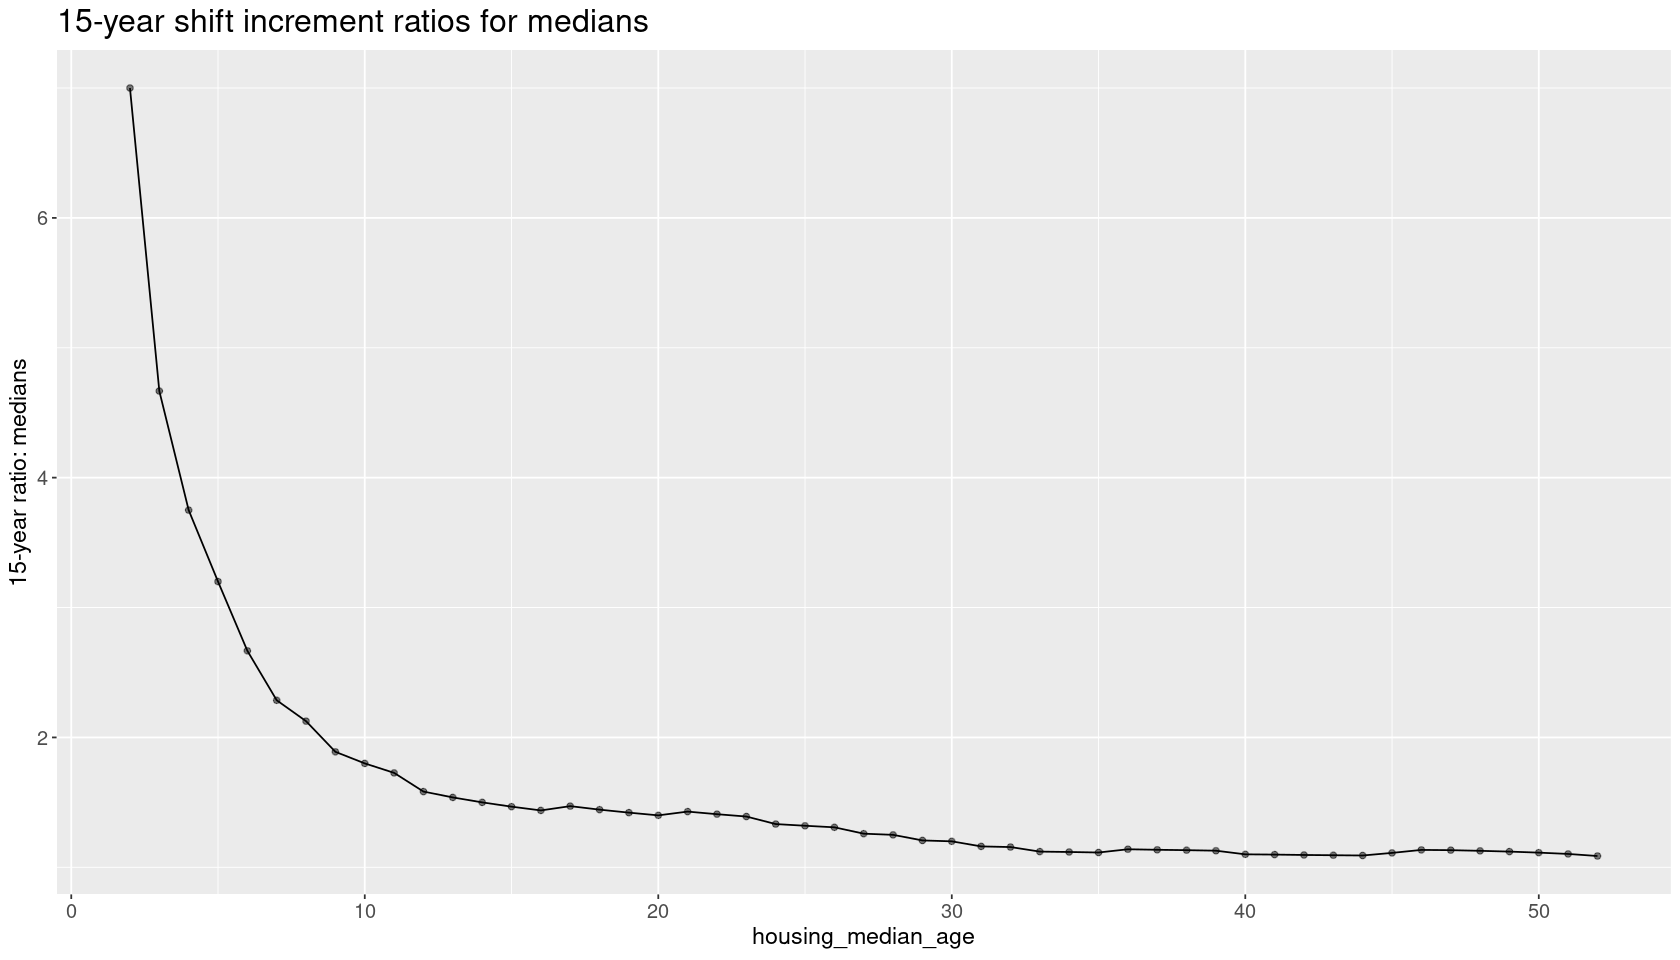

In [73]:
options(repr.plot.width= 14, repr.plot.height= 8)

p <- ggplot(df_rat03, aes(age, median_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("15-year ratio: medians") +
  geom_line() +
  ggtitle("15-year shift increment ratios for medians") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [67]:
# Model for predicting median_ratio at age = 52.

p03 <- lm(I(median_ratio^0.47) ~ I(age^-0.247) + I((age^-0.247)^2) , 
          data= df_rat04)
ans <- summary(p03)
ans[[1]] <- ""; ans



Call:
""

Residuals:
    Min      1Q  Median      3Q     Max 
-0.0388 -0.0140 -0.0039  0.0149  0.0436 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)
(Intercept)         1.6280     0.0763    21.3  < 2e-16
I(age^-0.247)      -3.6528     0.2768   -13.2  2.4e-16
I((age^-0.247)^2)   5.5597     0.2403    23.1  < 2e-16

Residual standard error: 0.0219 on 41 degrees of freedom
Multiple R-squared:  0.995,	Adjusted R-squared:  0.994 
F-statistic: 3.89e+03 on 2 and 41 DF,  p-value: <2e-16


In [68]:
ncvTest(p03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.12426, Df = 1, p = 0.724

In [69]:
residualPlots(p03, plot=FALSE)


                  Test stat Pr(>|Test stat|)
I(age^-0.247)          0.84             0.41
I((age^-0.247)^2)      0.64             0.53
Tukey test             0.46             0.65


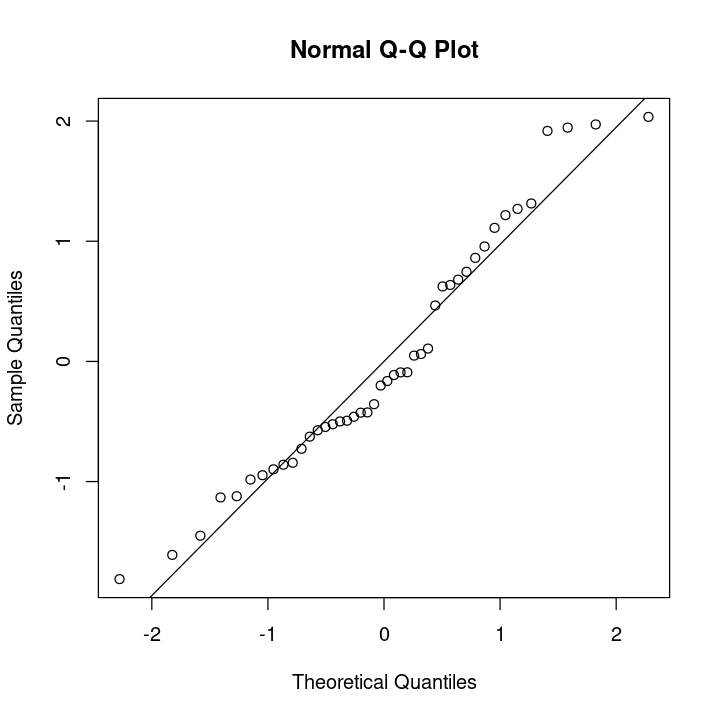

In [70]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(p03, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [71]:
# Prediction for median when age = 52.

newdat <- df_rat04[1, ]
newdat[1, ] <- c(52, rep(NA, 5))

ans <- predict.lm(p03, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.47); ans_transf
# 1.089

# 1.089 * 52 = 56.6

# The 95% CI is: [51.7, 61.8]


1 
1.0892

In [74]:
# What percent of the 1268 imputed values lie in the
# range, [68, 75]?  If 3% or more records are in this
# region, this will increase the median from what the
# model predicts.

total <- 1268
other <- nrow(dat[which((dat$housing_median_age >= 68) & (dat$housing_median_age <= 75)),])
(percent_other <- 100* round(other/total, 3))
paste0("The percent of imputed values not in [52, 67]: ", 
       as.character(percent_other))


[1] 3.6

[1] "The percent of imputed values not in [52, 67]: 3.6"

In [ ]:
### COMMENTS:

# The predicted median at age 52 is 56.6.  This is very much
# what we would expect with a predicted mean of 57.1.  With
# the current set of imputed values, the "actual" ratio at
# age 52 is 1.087.  1.087 * 52 = 56.5.  For ALL 1268 imputed
# values, the median is at 56.8.  The slight increase is 
# expected since 3.6% of the 1268 imputed values are not in
# the 15-year shift-increment window for age 52.

# In sum, models p02 and p03 provide good evidence for thinking
# that the current set of imputed values are consistent with
# the observed data.  In particular, it looks like the SHAPE of
# the distribution of imputed values is what it ought to be.
# This is critical because the shape we are settling on is not
# the one provided directly from the Gibbs sampler.


[1] 1268


 52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71 
 65 149 135 118 132 106  85  69  89  57  56  44  34  27  29  17  17  16   7   7 
 72  73  74  75 
  1   4   2   2 

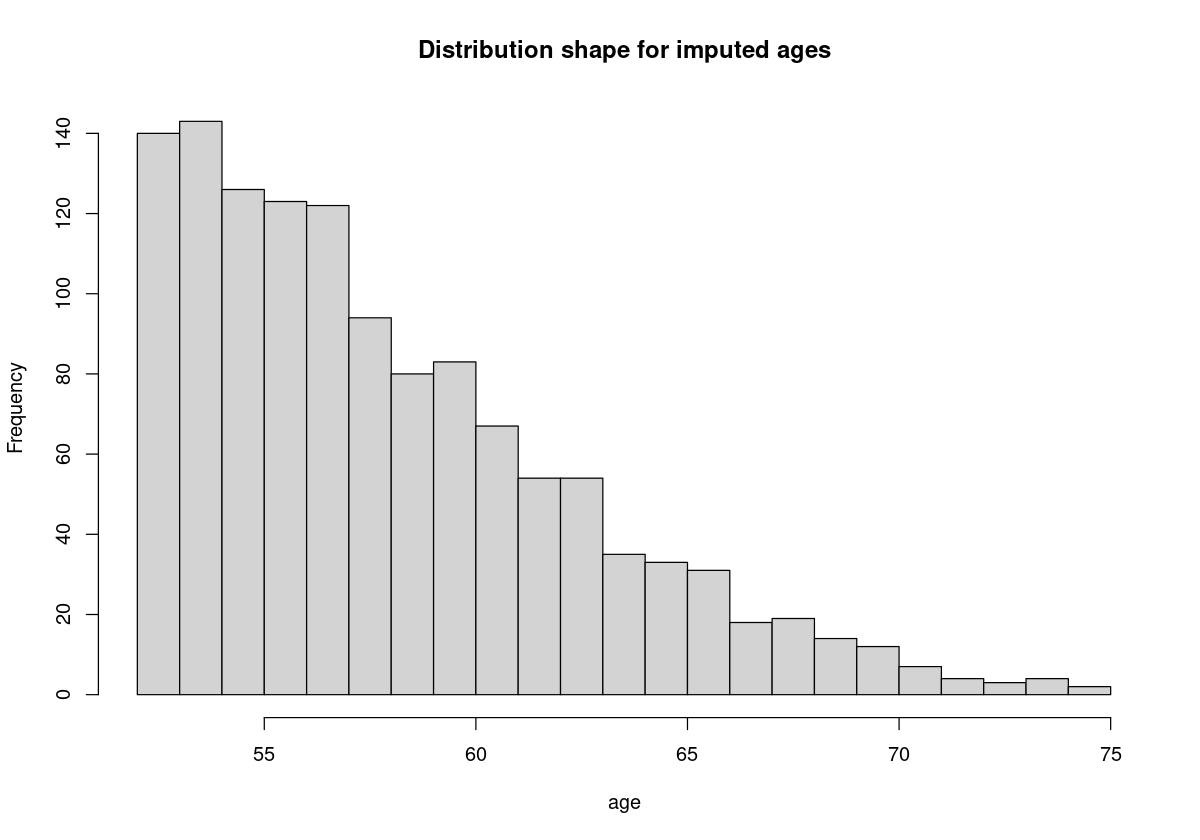

In [78]:
tmpdat <- dat[which(dat$housing_median_age >= 52), c("housing_median_age"),
              drop=FALSE]
nrow(tmpdat)
tmpdat$housing_median_age <- as.factor(round(tmpdat$housing_median_age))
table(tmpdat$housing_median_age)

options(repr.plot.width= 10, repr.plot.height= 7)
hist(dat[which(dat$housing_median_age >= 52), c("housing_median_age")],
     breaks=25, xlab="age", main="Distribution shape for imputed ages")


## Final Comments for Appendix A

The basic problem facing us with the capped data is that we need to impute values into a region for which we have no data.  And if the model we build for predicting housing_median_age has no data to work with in the region where the imputed values should lie, this model will nearly always generate predictions within the range of the data from which it was built.  The Gibbs sampler provides us with a solution to this problem.  But it is not a solution we should always accept without adjustments, for it can only yield a distribution for the imputed values that is the same as that built into our model assumptions for the response variable.

With the censored housing median age values, we are imputing values at the tail of the distribution.  Thus, we do not expect the imputed values to have a normal distribution.  We can get a better handle on the true, unobserved distribution if we can accurately predict their mean and/or median.  An accurate prediction not only tells us something about how fast the counts are dropping, but also something about how good the unadjusted output from the Gibbs sampler is.

In this appendix I have offered a *general* method for getting an accurate prediction of the mean of the true, unobserved values of the censored records.  We see another application of the method in Appendix B.  With an accurate prediction of the mean, we can adjust the Gibbs sampler output, if necessary, to fit the shape of the distribution of imputed values that we expect to see.  We end up with a much more plausible set of imputed values.  In fact, the imputed values are plausible enough that for certain purposes we can treat them as if they were observed data.  This is exactly what I do with the imputed values for the 4.8\% of the records with a censored median house value when I compute comparative root mean square error (rmse) scores.  The average error for our predictions for median house value then becomes an average over **all** Census districts in California and not just those with an expected median house value less than 500K.


